<a href="https://colab.research.google.com/github/Tongwu18/fu-yao/blob/main/Halle_1_RL%20%20311225%20%20608.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 数据清洗

In [19]:
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from typing import List, Tuple, Optional, Dict, Any
from dataclasses import dataclass, field
import copy
df = pd.read_excel("https://github.com/Tongwu18/fu-yao/raw/main/Halle1_311225.xlsx")
df

,本厂编号,类型,长,宽,高,体积,备注
0,00655TDR03003,门玻,740,760,760,0.427424,NaN
1,00655TDR03004,门玻,740,760,760,0.427424,NaN
2,B00514TDR06005,前挡,1350,1065,730,1.049557,NaN
3,B00443LFW00034,前挡,1680,1140,1150,2.202480,NaN
4,B00443LFW00034,前挡,1680,1140,1150,2.202480,NaN
...,...,...,...,...,...,...,...
8460,C00978TDR10006,门玻,900,1130,1110,1.128870,NaN
8461,C00978TDR10006,门玻,900,1130,1110,1.128870,NaN
8462,C00978TDR10006,门玻,900,1130,1110,1.128870,NaN
8463,C00978TDR10006,门玻,900,1130,1110,1.128870,NaN


In [20]:
"""
玻璃数据清洗
1. 本厂编号 → 数字ID
2. 按编号分组计数
3. 输出清洗后的工作表
"""

import pandas as pd
import numpy as np


def clean_glass_data(df, output_file="cleaned_glass_data.xlsx"):
    """
    清洗玻璃数据

    输入列: 本厂编号, 类型, 长, 宽, 高, 体积, 备注
    输出列: 玻璃ID, 本厂编号, 类型, 长, 宽, 长宽最大值, 高, 体积, 备注, 数量
    """
    print("="*60)
    print("Data Cleaning")
    print("="*60)

    print(f"\nRaw data: {len(df)} rows")
    print(f"Original columns: {df.columns.tolist()}")

    # 清理列名：去除空格
    df.columns = df.columns.str.strip()
    print(f"Cleaned columns: {df.columns.tolist()}")

    # 检测列名（支持多种可能的名称）
    id_col = next((c for c in df.columns if '编号' in c or 'ID' in c.upper()), None)
    type_col = next((c for c in df.columns if '类型' in c or 'type' in c.lower()), None)
    len_col = next((c for c in df.columns if c in ['长', '长度', 'length']), None)
    w_col = next((c for c in df.columns if c in ['宽', '宽度', 'width']), None)
    h_col = next((c for c in df.columns if c in ['高', '高度', 'height']), None)
    vol_col = next((c for c in df.columns if '体积' in c or 'volume' in c.lower()), None)
    note_col = next((c for c in df.columns if '备注' in c or 'note' in c.lower() or 'remark' in c.lower()), None)

    print(f"\nDetected: ID={id_col}, Type={type_col}, Length={len_col}, Width={w_col}, Height={h_col}, Volume={vol_col}, Note={note_col}")

    if id_col is None:
        raise ValueError("Cannot find ID column!")

    # 处理备注列：NaN→0, 转laichingen→1
    if note_col:
        df[note_col] = df[note_col].fillna(0)
        df[note_col] = df[note_col].apply(lambda x: 1 if isinstance(x, str) and 'laichingen' in x.lower() else (x if x != 0 else 0))
        print(f"\nNote column processed: NaN→0, laichingen→1")
        print(f"  Note=0 (Local): {(df[note_col] == 0).sum()} items")
        print(f"  Note=1 (Transfer): {(df[note_col] == 1).sum()} items")

    # 添加长宽最大值列（防止叉车倾倒）
    # 规则：如果最长边 <= 1300mm，则竖放（用最短边）；否则横放（用最长边）
    if len_col and w_col:
        def calc_placement_width(row):
            max_lw = max(row[len_col], row[w_col])
            min_lw = min(row[len_col], row[w_col])
            if max_lw <= 1300:
                # 小件竖放，用最短边
                return min_lw
            else:
                # 大件横放，用最长边
                return max_lw

        df['MaxLW'] = df.apply(calc_placement_width, axis=1)

        # 统计竖放和横放数量
        vertical_count = (df[[len_col, w_col]].max(axis=1) <= 1300).sum()
        horizontal_count = len(df) - vertical_count
        print(f"\nAdded MaxLW column (placement width):")
        print(f"  Vertical (max<=1300, use min): {vertical_count} items")
        print(f"  Horizontal (max>1300, use max): {horizontal_count} items")

    # 按本厂编号分组
    agg_cols = {}
    if type_col: agg_cols[type_col] = 'first'
    if len_col: agg_cols[len_col] = 'first'
    if w_col: agg_cols[w_col] = 'first'
    if 'MaxLW' in df.columns: agg_cols['MaxLW'] = 'first'
    if h_col: agg_cols[h_col] = 'first'
    if vol_col: agg_cols[vol_col] = 'first'
    if note_col: agg_cols[note_col] = 'first'

    grouped = df.groupby(id_col).agg(agg_cols).reset_index()
    grouped['Count'] = df.groupby(id_col).size().values
    grouped = grouped.rename(columns={id_col: 'PartNo'})

    # 标准化列名为英文
    rename_map = {}
    if type_col: rename_map[type_col] = 'Type'
    if len_col: rename_map[len_col] = 'Length'
    if w_col: rename_map[w_col] = 'Width'
    if h_col: rename_map[h_col] = 'Height'
    if vol_col: rename_map[vol_col] = 'Volume'
    if note_col: rename_map[note_col] = 'Note'
    grouped = grouped.rename(columns=rename_map)

    # 创建数字ID，按数量排序
    grouped = grouped.sort_values('Count', ascending=False).reset_index(drop=True)
    grouped.insert(0, 'GlassID', range(1, len(grouped) + 1))

    print(f"\nCleaned: {len(grouped)} glass types")
    print(f"Total boxes: {grouped['Count'].sum()}")

    # 统计信息
    if 'MaxLW' in grouped.columns and 'Height' in grouped.columns:
        print(f"\nDimension range:")
        print(f"  MaxLW: {grouped['MaxLW'].min()} - {grouped['MaxLW'].max()} mm")
        print(f"  Height: {grouped['Height'].min()} - {grouped['Height'].max()} mm")

    if 'Note' in grouped.columns:
        print(f"\nNote stats:")
        print(f"  Transfer(=1): {(grouped['Note'] == 1).sum()} types, {grouped[grouped['Note']==1]['Count'].sum()} boxes")
        print(f"  Local(=0): {(grouped['Note'] == 0).sum()} types, {grouped[grouped['Note']==0]['Count'].sum()} boxes")

    print(f"\nQuantity distribution:")
    print(f"  Max: {grouped['Count'].max()} boxes")
    print(f"  Min: {grouped['Count'].min()} boxes")
    print(f"  Avg: {grouped['Count'].mean():.1f} boxes")

    print(f"\nTop 10 glass types:")
    print("-"*90)
    for _, row in grouped.head(10).iterrows():
        size_str = f"MaxLW={row.get('MaxLW', '?')}, H={row.get('Height', '?')}"
        note_str = f"Note={row.get('Note', '-')}"
        print(f"  ID={row['GlassID']:3d} | {row['PartNo']} | {size_str}mm | {row['Count']} boxes | {note_str}")

    # 保存
    grouped.to_excel(output_file, index=False)
    print(f"\nSaved: {output_file}")

    return grouped


def split_by_location(df_clean, output_all="all_glass.xlsx", output_local="local_glass.xlsx"):
    """
    Split by Note: All data vs Local data (Note=0)
    """
    print("\n" + "="*60)
    print("Split Output")
    print("="*60)

    # All data
    df_all = df_clean.copy()
    df_all.to_excel(output_all, index=False)
    print(f"\nAll data: {len(df_all)} types, {df_all['Count'].sum()} boxes -> {output_all}")

    # Local data (Note=0)
    df_local = df_clean[df_clean['Note'] == 0].copy()
    df_local['GlassID'] = range(1, len(df_local) + 1)
    df_local.to_excel(output_local, index=False)
    print(f"Local data: {len(df_local)} types, {df_local['Count'].sum()} boxes -> {output_local}")

    return df_all, df_local


def plot_glass_analysis(df, title_prefix="All", save_prefix="all"):
    """
    Plot glass data analysis charts (English)
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set_theme(style="whitegrid")
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial']
    plt.rcParams['axes.unicode_minus'] = False

    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    fig.suptitle(f'{title_prefix} Glass Data Analysis (n={len(df)}, total={df["Count"].sum()} boxes)',
                 fontsize=14, fontweight='bold')

    # 1. MaxLW Distribution (用MaxLW代替Length)
    ax1 = axes[0, 0]
    sns.histplot(data=df, x='MaxLW', weights='Count', bins=30, kde=True, ax=ax1, color='steelblue')
    ax1.set_xlabel('Max(Length, Width) (mm)')
    ax1.set_ylabel('Box Count')
    ax1.set_title('MaxLW Distribution (weighted)')

    # 2. Height Distribution
    ax2 = axes[0, 1]
    sns.histplot(data=df, x='Height', weights='Count', bins=30, kde=True, ax=ax2, color='coral')
    ax2.set_xlabel('Height (mm)')
    ax2.set_ylabel('Box Count')
    ax2.set_title('Height Distribution (weighted)')

    # 3. Volume Distribution
    ax3 = axes[0, 2]
    sns.histplot(data=df, x='Volume', weights='Count', bins=30, kde=True, ax=ax3, color='green')
    ax3.set_xlabel('Volume (m³)')
    ax3.set_ylabel('Box Count')
    ax3.set_title('Volume Distribution (weighted)')

    # 4. Type Distribution
    ax4 = axes[1, 0]
    type_counts = df.groupby('Type')['Count'].sum().sort_values(ascending=True)
    colors = sns.color_palette('Set2', len(type_counts))
    bars = ax4.barh(type_counts.index, type_counts.values, color=colors)
    ax4.set_xlabel('Box Count')
    ax4.set_ylabel('Type')
    ax4.set_title('Type Distribution')
    for bar, val in zip(bars, type_counts.values):
        ax4.text(val + 10, bar.get_y() + bar.get_height()/2, f'{val}', va='center', fontsize=9)

    # 5. MaxLW vs Height Scatter (用MaxLW代替Length)
    ax5 = axes[1, 1]
    scatter = ax5.scatter(df['MaxLW'], df['Height'], s=df['Count']*5, c=df['Volume'],
                          cmap='viridis', alpha=0.6, edgecolors='black', linewidth=0.5)
    ax5.set_xlabel('Max(Length, Width) (mm)')
    ax5.set_ylabel('Height (mm)')
    ax5.set_title('MaxLW vs Height (size=count, color=volume)')
    plt.colorbar(scatter, ax=ax5, label='Volume')

    # 6. Quantity Distribution
    ax6 = axes[1, 2]
    sns.histplot(data=df, x='Count', bins=30, kde=True, ax=ax6, color='purple')
    ax6.set_xlabel('Boxes per Glass Type')
    ax6.set_ylabel('Glass Type Count')
    ax6.set_title('Quantity Distribution per Type')
    ax6.axvline(df['Count'].mean(), color='red', linestyle='--', label=f'Mean={df["Count"].mean():.1f}')
    ax6.legend()

    plt.tight_layout()
    filename = f'{save_prefix}_glass_analysis.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"\nChart saved: {filename}")

    return fig


def full_clean_and_plot(df, output_prefix="glass"):
    """
    Full workflow: Clean -> Split -> Plot
    """
    # 1. Clean
    df_clean = clean_glass_data(df, f"{output_prefix}_cleaned.xlsx")

    # 2. Split
    df_all, df_local = split_by_location(
        df_clean,
        f"{output_prefix}_all.xlsx",
        f"{output_prefix}_local.xlsx"
    )

    # 3. Plot
    print("\n" + "="*60)
    print("Generating Charts")
    print("="*60)

    plot_glass_analysis(df_all, "All Data", f"{output_prefix}_all")
    plot_glass_analysis(df_local, "Local Only (Note=0)", f"{output_prefix}_local")

    return df_clean, df_all, df_local


def quick_clean(filepath, output_file="cleaned_glass_data.xlsx"):
    """
    快速清洗（一键）
    """
    df = pd.read_excel(filepath)
    return clean_glass_data(df, output_file)


if __name__ == "__main__":
    print("""
用法:
    import pandas as pd
    from data_cleaner import clean_glass_data, quick_clean

    # 方式1: 直接从文件
    df_clean = quick_clean("原始数据.xlsx", "清洗后数据.xlsx")

    # 方式2: 从DataFrame
    df = pd.read_excel("原始数据.xlsx")
    df_clean = clean_glass_data(df, "清洗后数据.xlsx")
    """)


用法:
    import pandas as pd
    from data_cleaner import clean_glass_data, quick_clean

    # 方式1: 直接从文件
    df_clean = quick_clean("原始数据.xlsx", "清洗后数据.xlsx")

    # 方式2: 从DataFrame
    df = pd.read_excel("原始数据.xlsx")
    df_clean = clean_glass_data(df, "清洗后数据.xlsx")
    


Data Cleaning

Raw data: 8465 rows
Original columns: ['本厂编号        ', '类型', '长', '宽', '高', '体积', '备注']
Cleaned columns: ['本厂编号', '类型', '长', '宽', '高', '体积', '备注']

Detected: ID=本厂编号, Type=类型, Length=长, Width=宽, Height=高, Volume=体积, Note=备注

Note column processed: NaN→0, laichingen→1
  Note=0 (Local): 8465 items
  Note=1 (Transfer): 0 items

Added MaxLW column (placement width):
  Vertical (max<=1300, use min): 3100 items
  Horizontal (max>1300, use max): 5365 items

Cleaned: 748 glass types
Total boxes: 8465

Dimension range:
  MaxLW: 370 - 1950 mm
  Height: 350 - 1610 mm

Note stats:
  Transfer(=1): 0 types, 0 boxes
  Local(=0): 748 types, 8465 boxes

Quantity distribution:
  Max: 225 boxes
  Min: 1 boxes
  Avg: 11.3 boxes

Top 10 glass types:
------------------------------------------------------------------------------------------
  ID=  1 | B00866TRW00002 | MaxLW=1360, H=850mm | 225 boxes | Note=0
  ID=  2 | B89650LFW00008 | MaxLW=1600, H=1115mm | 135 boxes | Note=0
  ID=  3 | B0012

/tmp/ipython-input-517119234.py:222: UserWarning: Glyph 38376 (\N{CJK UNIFIED IDEOGRAPH-95E8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-517119234.py:222: UserWarning: Glyph 29627 (\N{CJK UNIFIED IDEOGRAPH-73BB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-517119234.py:222: UserWarning: Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-517119234.py:222: UserWarning: Glyph 26723 (\N{CJK UNIFIED IDEOGRAPH-6863}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-517119234.py:222: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-517119234.py:222: UserWarning: Glyph 25377 (\N{CJK UNIFIED IDEOGRAPH-6321}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-517119234.py:224: UserWarning: Glyph 38376 (\N{CJK UNIFIED IDEOGRAPH-95E8}) missi

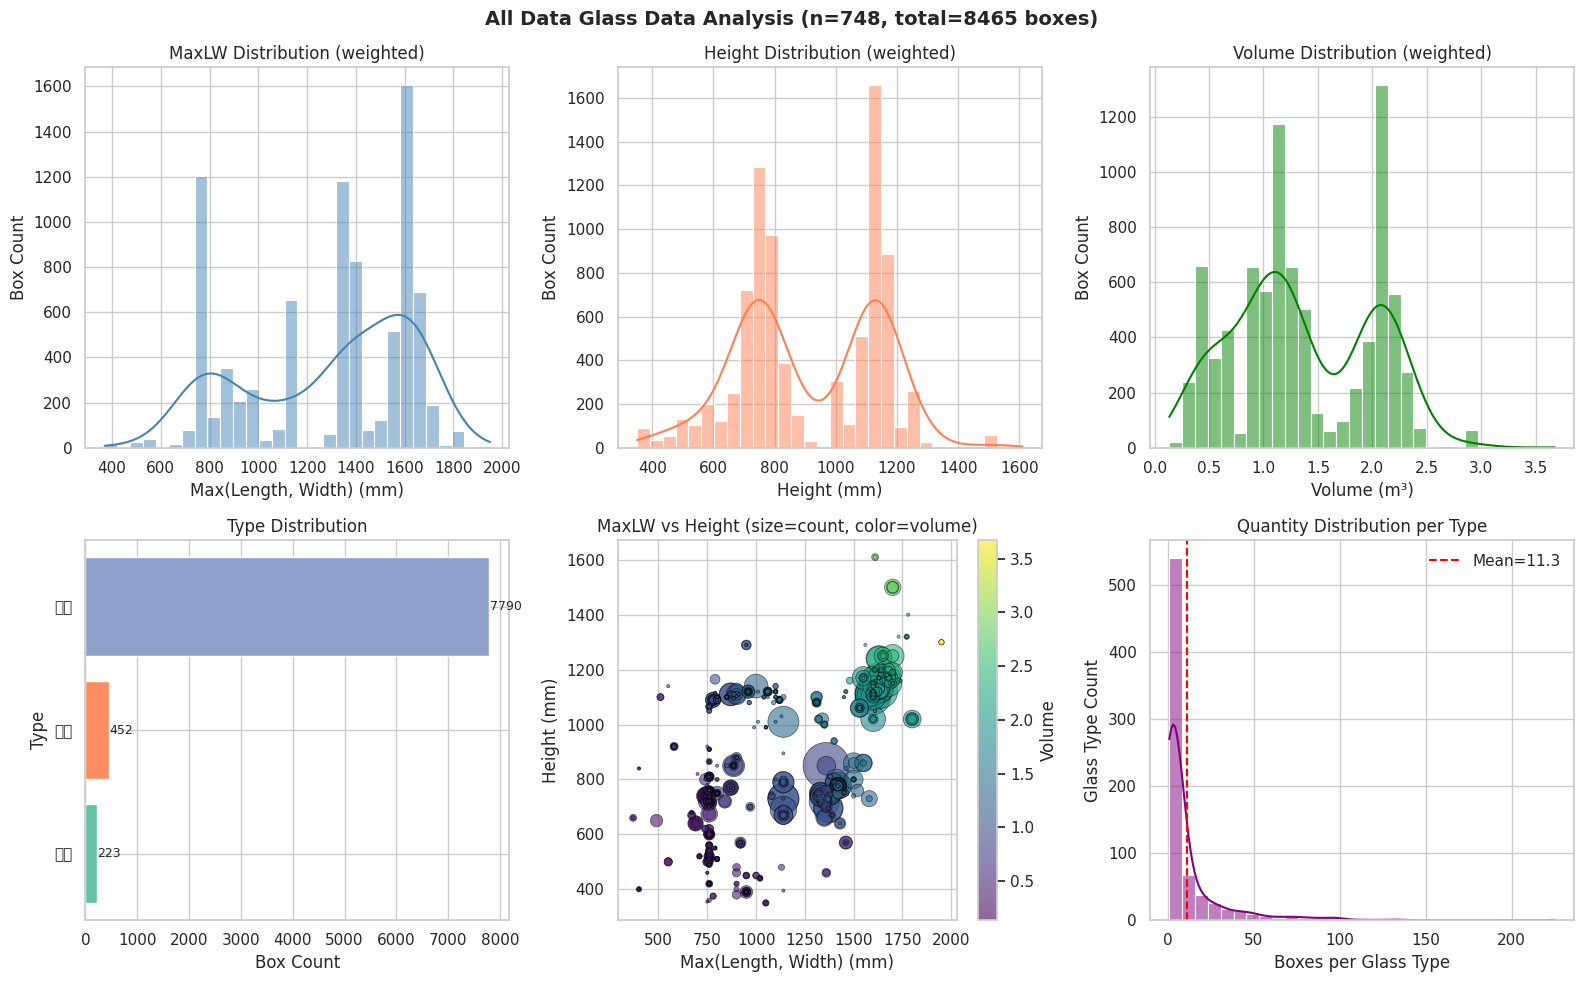


Chart saved: glass_all_glass_analysis.png


/tmp/ipython-input-517119234.py:222: UserWarning: Glyph 38376 (\N{CJK UNIFIED IDEOGRAPH-95E8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-517119234.py:222: UserWarning: Glyph 29627 (\N{CJK UNIFIED IDEOGRAPH-73BB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-517119234.py:222: UserWarning: Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-517119234.py:222: UserWarning: Glyph 26723 (\N{CJK UNIFIED IDEOGRAPH-6863}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-517119234.py:222: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-517119234.py:222: UserWarning: Glyph 25377 (\N{CJK UNIFIED IDEOGRAPH-6321}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-517119234.py:224: UserWarning: Glyph 38376 (\N{CJK UNIFIED IDEOGRAPH-95E8}) missi

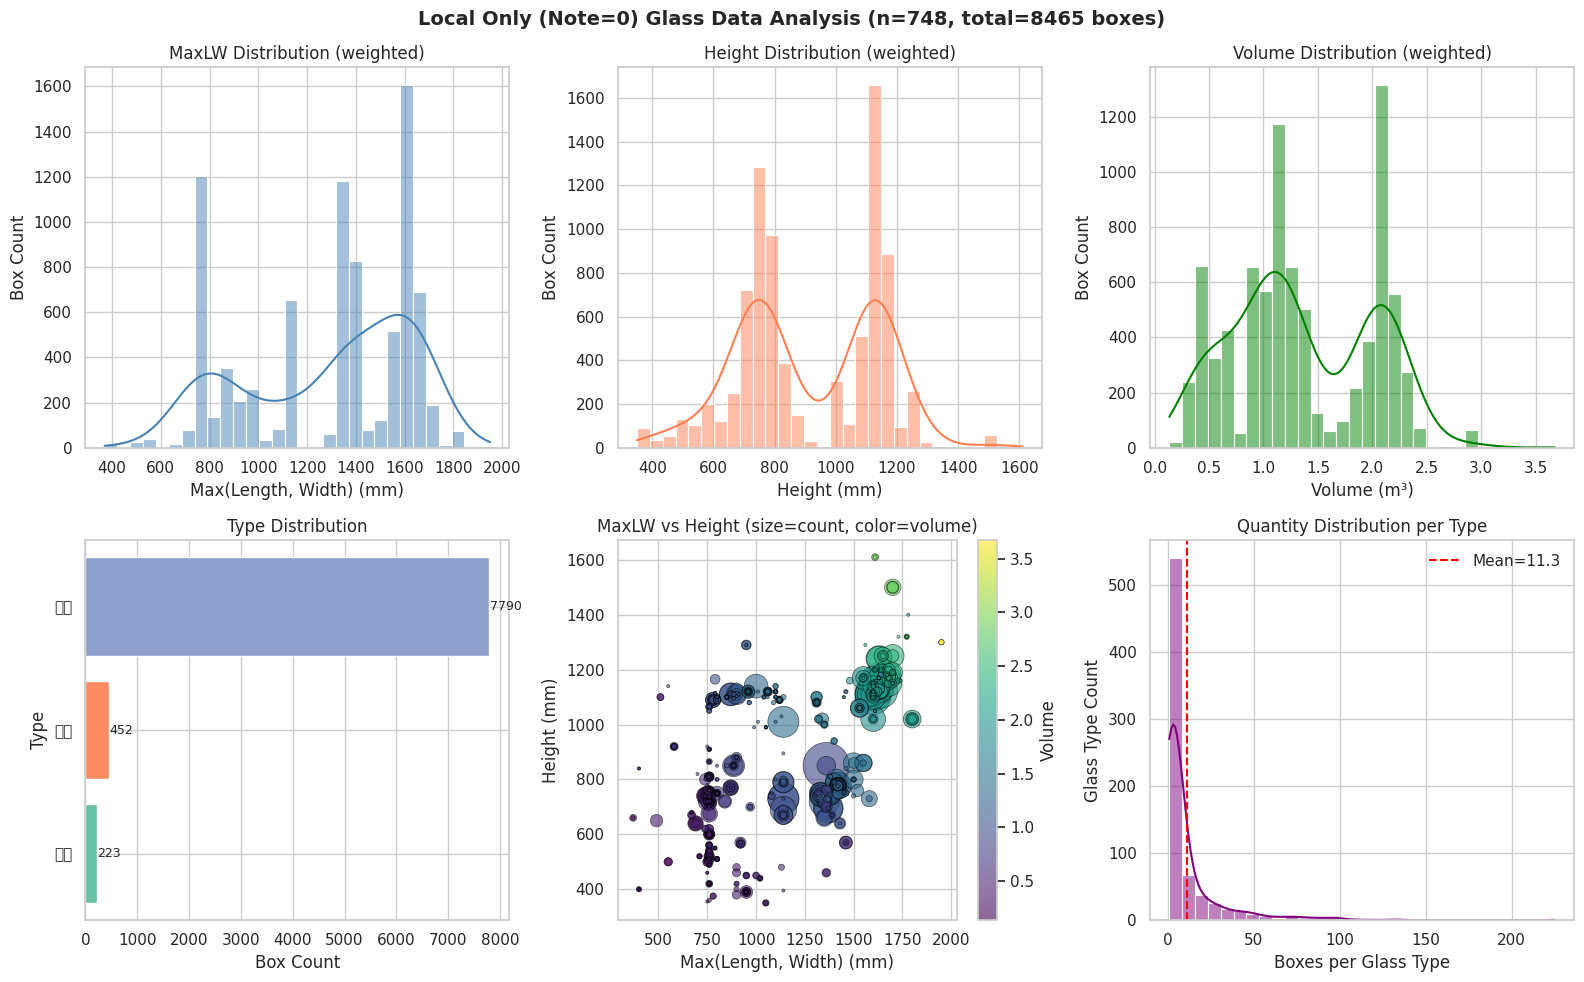


Chart saved: glass_local_glass_analysis.png


In [21]:
df_clean, df_all, df_local = full_clean_and_plot(df, output_prefix="glass")

# 聚类分析


In [22]:
"""
Glass Clustering Analysis
- Cluster by: MaxLW, Height (Type is just reference, not for clustering)
- Use Elbow method to find optimal cluster number
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


def prepare_features(df):
    """
    Prepare features for clustering: MaxLW, Height only
    (Type is reference only, not used in clustering)
    """
    # Features for clustering (only MaxLW and Height)
    features = df[['MaxLW', 'Height']].copy()

    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    print(f"Features prepared: MaxLW, Height")
    print(f"  MaxLW range: {df['MaxLW'].min()} - {df['MaxLW'].max()} mm")
    print(f"  Height range: {df['Height'].min()} - {df['Height'].max()} mm")
    print(f"  (Type is reference only, not used in clustering)")

    return features_scaled, scaler


def elbow_analysis(features_scaled, k_range=range(2, 21), title="All Data"):
    """
    Elbow method to find optimal K
    """
    print(f"\n{'='*60}")
    print(f"Elbow Analysis - {title}")
    print(f"{'='*60}")

    inertias = []
    silhouettes = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(features_scaled)
        inertias.append(kmeans.inertia_)

        sil_score = silhouette_score(features_scaled, kmeans.labels_)
        silhouettes.append(sil_score)

        print(f"  K={k:2d}: Inertia={kmeans.inertia_:,.0f}, Silhouette={sil_score:.3f}")

    return list(k_range), inertias, silhouettes


def find_elbow_point(k_range, inertias):
    """
    Find elbow point using the kneedle algorithm (simplified)
    """
    # Normalize
    k_norm = (np.array(k_range) - min(k_range)) / (max(k_range) - min(k_range))
    inertia_norm = (np.array(inertias) - min(inertias)) / (max(inertias) - min(inertias))

    # Find point with maximum distance to line from first to last
    p1 = np.array([k_norm[0], inertia_norm[0]])
    p2 = np.array([k_norm[-1], inertia_norm[-1]])

    distances = []
    for i in range(len(k_range)):
        p = np.array([k_norm[i], inertia_norm[i]])
        # Distance from point to line
        d = np.abs(np.cross(p2-p1, p1-p)) / np.linalg.norm(p2-p1)
        distances.append(d)

    elbow_idx = np.argmax(distances)
    return k_range[elbow_idx]


def plot_elbow(k_range, inertias, silhouettes, title="All Data", save_prefix="all"):
    """
    Plot Elbow curve and Silhouette score
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'Clustering Analysis - {title}', fontsize=14, fontweight='bold')

    # Find elbow point
    elbow_k = find_elbow_point(k_range, inertias)

    # 1. Elbow curve (Inertia)
    ax1 = axes[0]
    ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Inertia (Within-cluster sum of squares)')
    ax1.set_title('Elbow Method')
    ax1.grid(True, alpha=0.3)
    ax1.axvline(x=elbow_k, color='red', linestyle='--', label=f'Elbow at K={elbow_k}')
    ax1.legend()

    # 2. Silhouette score
    ax2 = axes[1]
    ax2.plot(k_range, silhouettes, 'go-', linewidth=2, markersize=8)
    ax2.set_xlabel('Number of Clusters (K)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis')
    ax2.grid(True, alpha=0.3)

    # Best silhouette
    best_sil_idx = np.argmax(silhouettes)
    best_sil_k = k_range[best_sil_idx]
    ax2.axvline(x=best_sil_k, color='red', linestyle='--', label=f'Best at K={best_sil_k}')
    ax2.legend()

    plt.tight_layout()
    filename = f'{save_prefix}_elbow_analysis.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()

    print(f"\nElbow point: K={elbow_k}")
    print(f"Best Silhouette: K={best_sil_k} (score={silhouettes[best_sil_idx]:.3f})")
    print(f"Chart saved: {filename}")

    return elbow_k, best_sil_k


def cluster_glass(df, n_clusters, features_scaled):
    """
    Perform clustering with specified K
    """
    print(f"\n{'='*60}")
    print(f"Clustering with K={n_clusters}")
    print(f"{'='*60}")

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df_result = df.copy()
    df_result['Cluster'] = kmeans.fit_predict(features_scaled)

    # Get cluster centers (in original scale)
    centers = kmeans.cluster_centers_

    # Cluster statistics
    print(f"\nCluster Statistics:")
    print("-"*80)

    cluster_stats = []
    for c in range(n_clusters):
        cluster_df = df_result[df_result['Cluster'] == c]
        stats = {
            'Cluster': c,
            'Count_Types': len(cluster_df),
            'Count_Boxes': cluster_df['Count'].sum(),
            'MaxLW_min': cluster_df['MaxLW'].min(),
            'MaxLW_max': cluster_df['MaxLW'].max(),
            'MaxLW_mean': cluster_df['MaxLW'].mean(),
            'Height_min': cluster_df['Height'].min(),
            'Height_max': cluster_df['Height'].max(),
            'Height_mean': cluster_df['Height'].mean(),
            'Types': cluster_df['Type'].value_counts().to_dict() if 'Type' in cluster_df.columns else {}
        }
        cluster_stats.append(stats)

        print(f"\nCluster {c}:")
        print(f"  Glass types: {stats['Count_Types']}, Total boxes: {stats['Count_Boxes']}")
        print(f"  MaxLW: {stats['MaxLW_min']:.0f} - {stats['MaxLW_max']:.0f} mm (mean: {stats['MaxLW_mean']:.0f})")
        print(f"  Height: {stats['Height_min']:.0f} - {stats['Height_max']:.0f} mm (mean: {stats['Height_mean']:.0f})")
        if stats['Types']:
            print(f"  Types: {stats['Types']}")

    return df_result, cluster_stats, kmeans


def plot_clusters(df_result, title="All Data", save_prefix="all"):
    """
    Visualize clustering results
    """
    n_clusters = df_result['Cluster'].nunique()

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle(f'Clustering Results - {title} (K={n_clusters})', fontsize=14, fontweight='bold')

    palette = sns.color_palette('tab10', n_clusters)

    # 1. MaxLW vs Height scatter (main plot)
    ax1 = axes[0, 0]
    for c in range(n_clusters):
        cluster_df = df_result[df_result['Cluster'] == c]
        ax1.scatter(cluster_df['MaxLW'], cluster_df['Height'],
                   s=cluster_df['Count']*5, alpha=0.6,
                   label=f'Cluster {c} (n={len(cluster_df)})', color=palette[c],
                   edgecolors='black', linewidth=0.3)
    ax1.set_xlabel('MaxLW (mm)')
    ax1.set_ylabel('Height (mm)')
    ax1.set_title('MaxLW vs Height by Cluster (size=box count)')
    ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)

    # 2. Cluster size (box count)
    ax2 = axes[0, 1]
    cluster_boxes = df_result.groupby('Cluster')['Count'].sum().sort_index()
    bars = ax2.bar(cluster_boxes.index, cluster_boxes.values, color=palette)
    ax2.set_xlabel('Cluster')
    ax2.set_ylabel('Total Boxes')
    ax2.set_title('Boxes per Cluster')
    for bar, val in zip(bars, cluster_boxes.values):
        ax2.text(bar.get_x() + bar.get_width()/2, val + 10, f'{val}', ha='center', fontsize=9)

    # 3. MaxLW distribution by cluster
    ax3 = axes[1, 0]
    for c in range(n_clusters):
        cluster_df = df_result[df_result['Cluster'] == c]
        ax3.hist(cluster_df['MaxLW'], bins=20, alpha=0.5, label=f'Cluster {c}', color=palette[c])
    ax3.set_xlabel('MaxLW (mm)')
    ax3.set_ylabel('Count')
    ax3.set_title('MaxLW Distribution by Cluster')
    ax3.legend()

    # 4. Height distribution by cluster
    ax4 = axes[1, 1]
    for c in range(n_clusters):
        cluster_df = df_result[df_result['Cluster'] == c]
        ax4.hist(cluster_df['Height'], bins=20, alpha=0.5, label=f'Cluster {c}', color=palette[c])
    ax4.set_xlabel('Height (mm)')
    ax4.set_ylabel('Count')
    ax4.set_title('Height Distribution by Cluster')
    ax4.legend()

    plt.tight_layout()
    filename = f'{save_prefix}_clusters.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"Chart saved: {filename}")

    return fig


def create_merged_specs(df_result, cluster_stats):
    """
    Create merged specifications based on clusters
    For packing: use MaxLW_max and Height_max of each cluster
    """
    print(f"\n{'='*60}")
    print("Merged Specifications for Packing")
    print("{'='*60}")

    merged_specs = []
    for stats in cluster_stats:
        spec = {
            'Cluster': stats['Cluster'],
            'Std_MaxLW': stats['MaxLW_max'],  # Use max for safety
            'Std_Height': stats['Height_max'],  # Use max for safety
            'Glass_Types': stats['Count_Types'],
            'Total_Boxes': stats['Count_Boxes'],
        }
        merged_specs.append(spec)
        print(f"Cluster {spec['Cluster']}: Std_MaxLW={spec['Std_MaxLW']:.0f}, Std_Height={spec['Std_Height']:.0f} "
              f"({spec['Glass_Types']} types, {spec['Total_Boxes']} boxes)")

    return pd.DataFrame(merged_specs)


def full_cluster_analysis(df, k_range=range(2, 21), title="All Data", save_prefix="all",
                          chosen_k=None):
    """
    Full clustering workflow:
    1. Prepare features (MaxLW, Height)
    2. Elbow analysis
    3. Cluster with optimal/chosen K
    4. Visualize results
    5. Create merged specs

    Args:
        df: DataFrame with MaxLW, Height, Count columns
        k_range: range of K values to test
        title: title for plots
        save_prefix: prefix for saved files
        chosen_k: if specified, use this K instead of elbow point

    Returns:
        df_result: DataFrame with Cluster column added
        cluster_stats: list of cluster statistics
        merged_specs: DataFrame of merged specifications
    """
    print(f"\n{'='*60}")
    print(f"Full Cluster Analysis - {title}")
    print(f"{'='*60}")
    print(f"Data: {len(df)} glass types, {df['Count'].sum()} boxes")

    # 1. Prepare features
    features_scaled, scaler = prepare_features(df)

    # 2. Elbow analysis
    k_list, inertias, silhouettes = elbow_analysis(features_scaled, k_range, title)
    elbow_k, best_sil_k = plot_elbow(k_list, inertias, silhouettes, title, save_prefix)

    # 3. Choose K
    if chosen_k is None:
        optimal_k = elbow_k
        print(f"\nUsing elbow point K={optimal_k}")
    else:
        optimal_k = chosen_k
        print(f"\nUsing specified K={optimal_k}")

    # 4. Cluster
    df_result, cluster_stats, kmeans = cluster_glass(df, optimal_k, features_scaled)

    # 5. Visualize
    plot_clusters(df_result, title, save_prefix)

    # 6. Create merged specs
    merged_specs = create_merged_specs(df_result, cluster_stats)

    # 7. Save results
    df_result.to_excel(f'{save_prefix}_clustered.xlsx', index=False)
    merged_specs.to_excel(f'{save_prefix}_merged_specs.xlsx', index=False)
    print(f"\nSaved: {save_prefix}_clustered.xlsx")
    print(f"Saved: {save_prefix}_merged_specs.xlsx")

    return df_result, cluster_stats, merged_specs


# Quick function for both all and local data
def analyze_all_and_local(df_all, df_local, k_range=range(2, 21), chosen_k_all=None, chosen_k_local=None):
    """
    Run cluster analysis on both all data and local data
    """
    print("\n" + "="*80)
    print("CLUSTERING ANALYSIS")
    print("="*80)

    # All data
    result_all, stats_all, specs_all = full_cluster_analysis(
        df_all, k_range, "All Data", "all", chosen_k_all
    )

    # Local data
    result_local, stats_local, specs_local = full_cluster_analysis(
        df_local, k_range, "Local Only", "local", chosen_k_local
    )

    return {
        'all': {'result': result_all, 'stats': stats_all, 'specs': specs_all},
        'local': {'result': result_local, 'stats': stats_local, 'specs': specs_local}
    }


if __name__ == "__main__":
    print("""
Usage:
    from cluster_analysis import full_cluster_analysis, analyze_all_and_local

    # Single dataset analysis
    df_result, stats, merged_specs = full_cluster_analysis(
        df_local,
        k_range=range(2, 21),
        title="Local Data",
        save_prefix="local",
        chosen_k=None  # None = auto (elbow), or specify like chosen_k=8
    )

    # Both all and local
    results = analyze_all_and_local(df_all, df_local)
    """)


Usage:
    from cluster_analysis import full_cluster_analysis, analyze_all_and_local

    # Single dataset analysis
    df_result, stats, merged_specs = full_cluster_analysis(
        df_local,
        k_range=range(2, 21),
        title="Local Data",
        save_prefix="local",
        chosen_k=None  # None = auto (elbow), or specify like chosen_k=8
    )

    # Both all and local
    results = analyze_all_and_local(df_all, df_local)
    



Full Cluster Analysis - Local Data
Data: 748 glass types, 8465 boxes
Features prepared: MaxLW, Height
  MaxLW range: 370 - 1950 mm
  Height range: 350 - 1610 mm
  (Type is reference only, not used in clustering)

Elbow Analysis - Local Data
  K= 2: Inertia=666, Silhouette=0.488
  K= 3: Inertia=418, Silhouette=0.499
  K= 4: Inertia=228, Silhouette=0.583
  K= 5: Inertia=141, Silhouette=0.612
  K= 6: Inertia=121, Silhouette=0.590
  K= 7: Inertia=104, Silhouette=0.585
  K= 8: Inertia=90, Silhouette=0.567
  K= 9: Inertia=78, Silhouette=0.555
  K=10: Inertia=73, Silhouette=0.534
  K=11: Inertia=64, Silhouette=0.554
  K=12: Inertia=60, Silhouette=0.516
  K=13: Inertia=54, Silhouette=0.547
  K=14: Inertia=51, Silhouette=0.521
  K=15: Inertia=46, Silhouette=0.521
  K=16: Inertia=42, Silhouette=0.542
  K=17: Inertia=38, Silhouette=0.491
  K=18: Inertia=36, Silhouette=0.510
  K=19: Inertia=34, Silhouette=0.519
  K=20: Inertia=31, Silhouette=0.511


/tmp/ipython-input-1876271985.py:76: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  d = np.abs(np.cross(p2-p1, p1-p)) / np.linalg.norm(p2-p1)


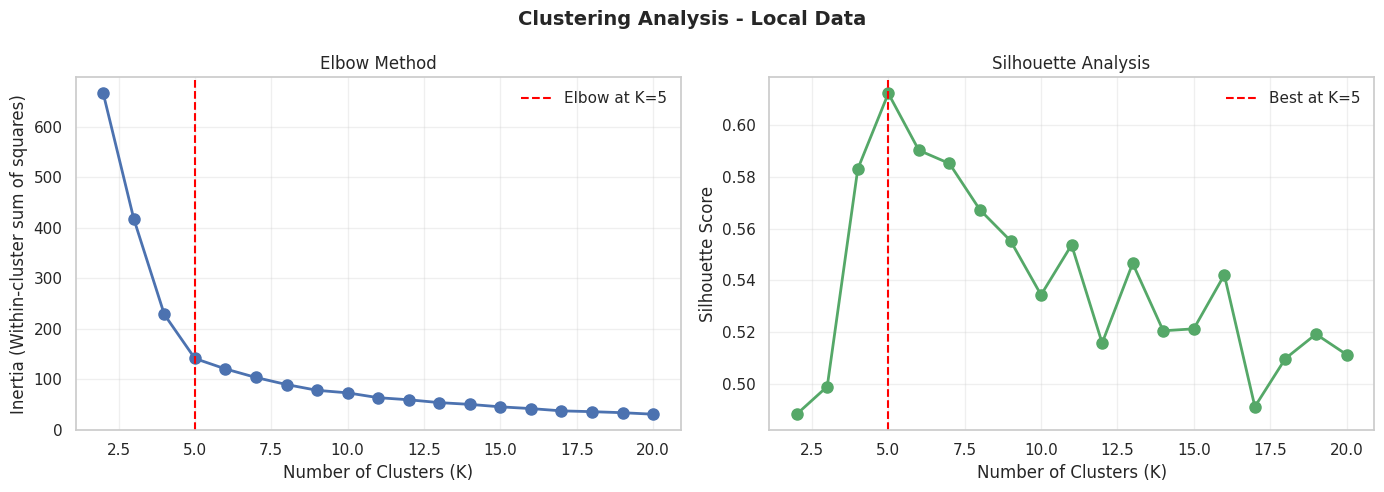


Elbow point: K=5
Best Silhouette: K=5 (score=0.612)
Chart saved: local_elbow_analysis.png

Using elbow point K=5

Clustering with K=5

Cluster Statistics:
--------------------------------------------------------------------------------

Cluster 0:
  Glass types: 176, Total boxes: 1162
  MaxLW: 370 - 970 mm (mean: 762)
  Height: 640 - 920 mm (mean: 767)
  Types: {'前挡': 154, '门玻': 12, '后档': 10}

Cluster 1:
  Glass types: 167, Total boxes: 3106
  MaxLW: 1310 - 1950 mm (mean: 1606)
  Height: 1000 - 1610 mm (mean: 1154)
  Types: {'前挡': 148, '后档': 11, '门玻': 8}

Cluster 2:
  Glass types: 127, Total boxes: 2786
  MaxLW: 1080 - 1580 mm (mean: 1357)
  Height: 460 - 940 mm (mean: 746)
  Types: {'前挡': 117, '后档': 6, '门玻': 4}

Cluster 3:
  Glass types: 128, Total boxes: 817
  MaxLW: 510 - 1140 mm (mean: 939)
  Height: 990 - 1290 mm (mean: 1100)
  Types: {'前挡': 103, '后档': 15, '门玻': 10}

Cluster 4:
  Glass types: 150, Total boxes: 594
  MaxLW: 400 - 1140 mm (mean: 813)
  Height: 350 - 620 mm (mean: 4

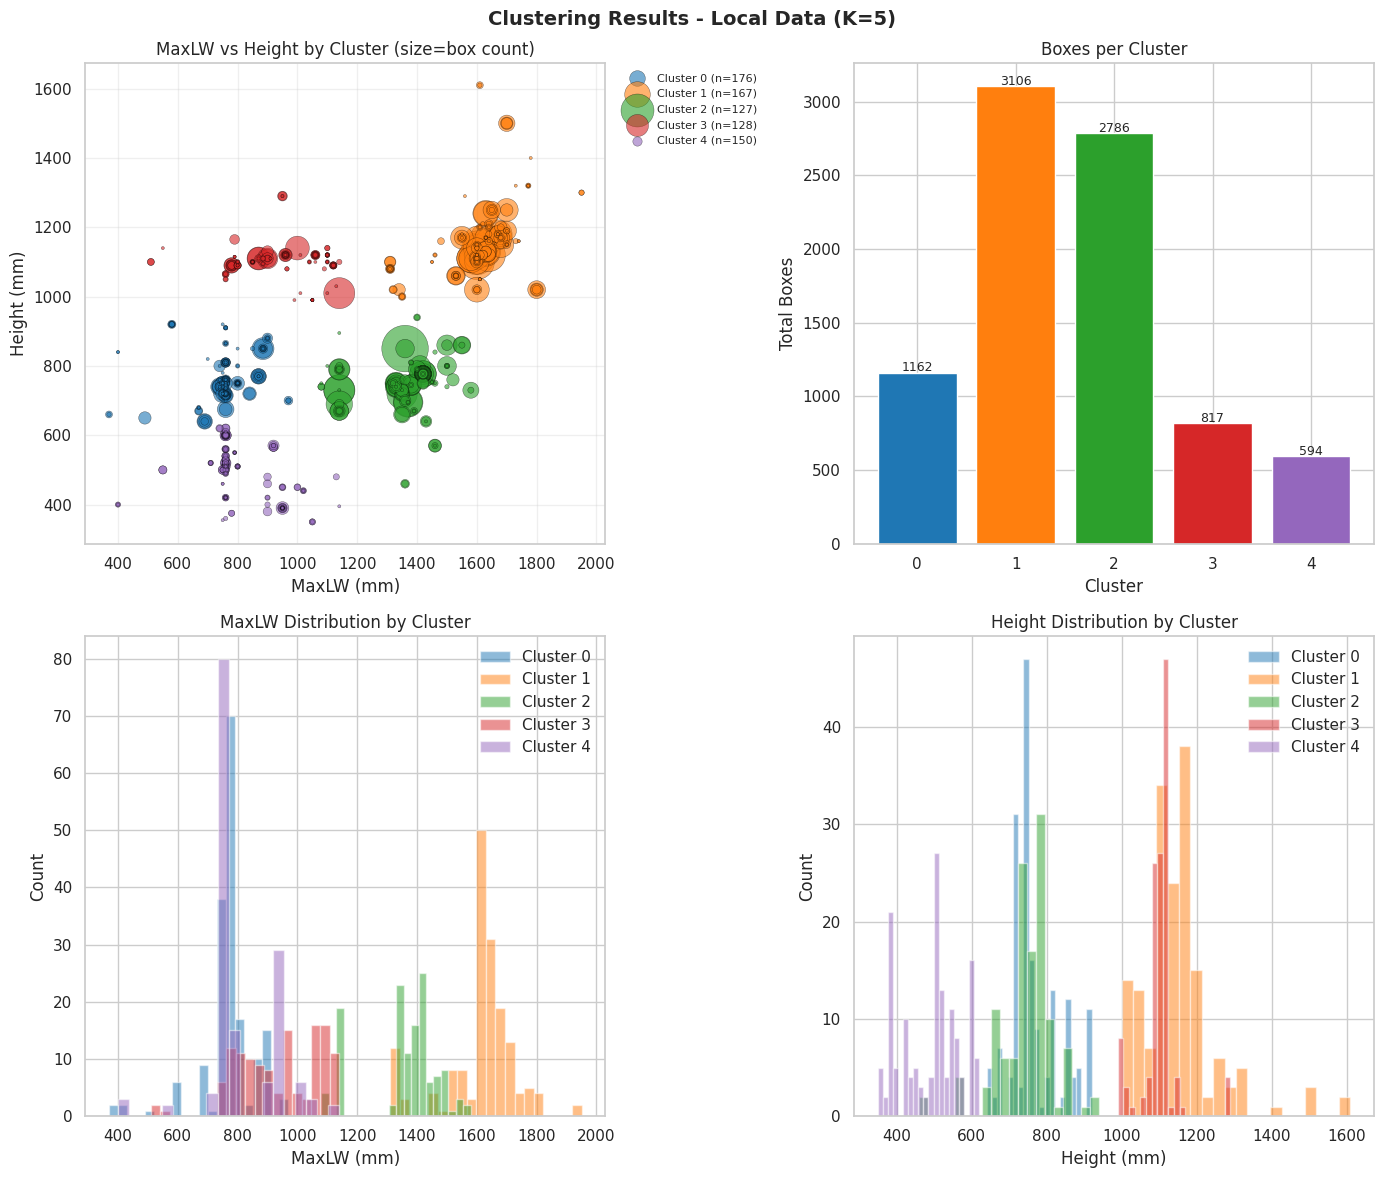

Chart saved: local_clusters.png

Merged Specifications for Packing
{'='*60}
Cluster 0: Std_MaxLW=970, Std_Height=920 (176 types, 1162 boxes)
Cluster 1: Std_MaxLW=1950, Std_Height=1610 (167 types, 3106 boxes)
Cluster 2: Std_MaxLW=1580, Std_Height=940 (127 types, 2786 boxes)
Cluster 3: Std_MaxLW=1140, Std_Height=1290 (128 types, 817 boxes)
Cluster 4: Std_MaxLW=1140, Std_Height=620 (150 types, 594 boxes)

Saved: local_clustered.xlsx
Saved: local_merged_specs.xlsx


In [23]:
df_result, stats, merged_specs = full_cluster_analysis(
    df_local,
    k_range=range(2, 21),
    title="Local Data",
    save_prefix="local"
)

# 环境


In [24]:
"""
Glass Shelf Packing Optimization - New Warehouse
- Shelf height: 7800mm
- Shelf span width: 3600mm or 2700mm (two options)
- Shelf depth: 1100mm
- Target: Minimize total floor area, max 4 config types
"""

import numpy as np
import pandas as pd
from collections import Counter, defaultdict

# ============================================
# Parameters
# ============================================
SHELF_H = 7900.0         # Shelf height (mm)
SHELF_W_OPTIONS = [3600.0, 2700.0]  # Shelf span width options (mm)
SHELF_DEPTH = 1300.0     # Shelf depth (mm)
SEP = 220               # Separator thickness (mm)
GAP = 90                # Gap between glass (mm)
MAX_STACK1 = 4           # Max stack on first layer
MAX_STACK2 = 2           # Max stack on other layers
MAX_POS_LAYER1 = 99      # Max positions on first layer (unlimited)
MAX_POS_LAYER2 = 99       # Max positions on layer 2+ (stability)
MIN_LAYERS = 3           # Minimum layers per shelf (stability)
W_STEP = 10              # Width merge step (mm)


def load_and_merge(df, w_step=W_STEP):
    """
    Load data and merge width
    Expected columns: MaxLW, Height, Count, GlassID/PartNo
    """
    print(f"{'='*60}")
    print("Loading and Merging Data")
    print(f"{'='*60}")

    # Detect columns
    maxlw_col = next((c for c in df.columns if 'MaxLW' in c or 'maxlw' in c.lower()), None)
    h_col = next((c for c in df.columns if c == 'Height' or c == '高'), None)
    cnt_col = next((c for c in df.columns if c == 'Count' or c == '数量'), None)
    id_col = next((c for c in df.columns if 'GlassID' in c or 'PartNo' in c or 'ID' in c), None)

    print(f"Detected columns: MaxLW={maxlw_col}, Height={h_col}, Count={cnt_col}, ID={id_col}")

    if not all([maxlw_col, h_col, cnt_col]):
        raise ValueError(f"Missing required columns. Found: {df.columns.tolist()}")

    df = df.copy()
    df['orig_w'] = df[maxlw_col].astype(float)  # Use MaxLW as width
    df['orig_h'] = df[h_col].astype(float)
    df['count'] = df[cnt_col].astype(int)
    df['glass_id'] = df[id_col] if id_col else range(len(df))

    # Merge width only
    df['std_w'] = np.ceil(df['orig_w'] / w_step) * w_step
    df['std_h'] = df['orig_h']

    n_orig = len(df)
    n_merged = len(df.groupby(['std_w', 'std_h']))

    print(f"\nGlass specs: {n_orig} -> {n_merged} (width step {w_step}mm)")
    print(f"Total boxes: {df['count'].sum()}")
    print(f"MaxLW range: {df['orig_w'].min():.0f} - {df['orig_w'].max():.0f} mm")
    print(f"Height range: {df['orig_h'].min():.0f} - {df['orig_h'].max():.0f} mm")

    return df


def pack_single_width(df, shelf_w, min_layers=MIN_LAYERS, min_layer_h=100):
    """
    Pack glass into shelves with specified width
    Constraints:
    - Layer 2+ max 6 positions
    - Minimum 3 layers per shelf
    """
    print(f"\n{'='*60}")
    print(f"Packing with Shelf Width = {shelf_w}mm")
    print(f"Shelf dimensions: {shelf_w} x {SHELF_H} x {SHELF_DEPTH} mm")
    print(f"Constraints: min {min_layers} layers, layer 2+ max {MAX_POS_LAYER2} positions")
    print(f"{'='*60}")

    # Expand glass list
    glasses = []
    for _, row in df.iterrows():
        for _ in range(row['count']):
            glasses.append({
                'id': row['glass_id'],
                'std_w': row['std_w'],
                'std_h': row['std_h'],
                'orig_w': row['orig_w'],
                'orig_h': row['orig_h']
            })

    # Sort by area descending
    glasses.sort(key=lambda g: -g['std_w'] * g['std_h'])

    shelves = []

    for g in glasses:
        gw, gh, gid = g['std_w'], g['std_h'], g['id']
        placed = False

        # Check if glass fits in shelf width
        if gw > shelf_w:
            print(f"Warning: Glass {gid} width {gw}mm > shelf width {shelf_w}mm, skipped")
            continue

        for shelf in shelves:
            # 1. Try stacking
            for li, layer in enumerate(shelf['layers']):
                for pos in layer['positions']:
                    if pos['id'] == gid:
                        max_stack = MAX_STACK1 if li == 0 else MAX_STACK2
                        if pos['stack'] < max_stack:
                            new_h = gh * (pos['stack'] + 1)
                            new_layer_h = max(layer['height'], new_h)

                            test_total = sum(l['height'] for l in shelf['layers']) + (len(shelf['layers'])-1)*SEP
                            test_total += new_layer_h - layer['height']

                            if test_total <= SHELF_H:
                                pos['stack'] += 1
                                layer['height'] = new_layer_h
                                placed = True
                                break
                if placed:
                    break
            if placed:
                break

            # 2. New position in existing layer
            for li, layer in enumerate(shelf['layers']):
                # Check position limit (layer 2+ max 6)
                max_pos = MAX_POS_LAYER1 if li == 0 else MAX_POS_LAYER2
                if len(layer['positions']) >= max_pos:
                    continue

                if gh > layer['height']:
                    continue
                used_w = sum(p['w'] for p in layer['positions'])
                if layer['positions']:
                    used_w += GAP * len(layer['positions'])
                if used_w + gw <= shelf_w:
                    layer['positions'].append({
                        'id': gid, 'w': gw, 'h': gh,
                        'orig_w': g['orig_w'], 'orig_h': g['orig_h'], 'stack': 1
                    })
                    placed = True
                    break
            if placed:
                break

            # 3. New layer
            n_layers = len(shelf['layers'])
            total_h = sum(l['height'] for l in shelf['layers']) + n_layers * SEP
            remaining = SHELF_H - total_h

            if gh <= remaining and remaining >= gh:
                shelf['layers'].append({
                    'height': gh,
                    'positions': [{'id': gid, 'w': gw, 'h': gh,
                                   'orig_w': g['orig_w'], 'orig_h': g['orig_h'], 'stack': 1}]
                })
                placed = True
                break

        # 4. New shelf (must have at least min_layers capacity)
        if not placed:
            # Estimate if we can have min_layers
            # Use average layer height as estimate
            avg_layer_h = gh  # Start with current glass height
            min_total_h = avg_layer_h * min_layers + (min_layers - 1) * SEP

            if min_total_h <= SHELF_H:
                shelves.append({
                    'width': shelf_w,
                    'layers': [{
                        'height': gh,
                        'positions': [{'id': gid, 'w': gw, 'h': gh,
                                       'orig_w': g['orig_w'], 'orig_h': g['orig_h'], 'stack': 1}]
                    }]
                })
            else:
                print(f"Warning: Glass {gid} height {gh}mm too tall for {min_layers}-layer shelf")

    total_boxes = sum(
        pos['stack']
        for s in shelves
        for l in s['layers']
        for pos in l['positions']
    )

    # Calculate floor area
    total_area_mm2 = len(shelves) * shelf_w * SHELF_DEPTH
    total_area_m2 = total_area_mm2 / 1_000_000  # Convert to m²

    print(f"\nResults:")
    print(f"  Shelves: {len(shelves)}")
    print(f"  Boxes: {total_boxes}")
    print(f"  Floor area: {total_area_m2:.2f} m²")

    return shelves, total_area_m2


def pack_mixed_width(df, min_layers=2):
    """
    Pack glass using mixed shelf widths (3600 and 2700)
    Strategy: Use narrower shelf (2700) when glass fits, otherwise use 3600
    """
    print(f"\n{'='*60}")
    print("Packing with Mixed Shelf Widths")
    print(f"Options: {SHELF_W_OPTIONS}mm")
    print(f"{'='*60}")

    # Check glass size distribution
    small_w = min(SHELF_W_OPTIONS)  # 2700
    large_w = max(SHELF_W_OPTIONS)  # 3600

    fit_small = (df['std_w'] <= small_w).sum()
    fit_large_only = ((df['std_w'] > small_w) & (df['std_w'] <= large_w)).sum()
    too_large = (df['std_w'] > large_w).sum()

    print(f"\nGlass width distribution:")
    print(f"  Fits {small_w}mm: {fit_small} types ({fit_small/len(df)*100:.1f}%)")
    print(f"  Needs {large_w}mm: {fit_large_only} types ({fit_large_only/len(df)*100:.1f}%)")
    print(f"  Too large: {too_large} types")

    # Expand and sort glass list
    glasses = []
    for _, row in df.iterrows():
        for _ in range(row['count']):
            glasses.append({
                'id': row['glass_id'],
                'std_w': row['std_w'],
                'std_h': row['std_h'],
                'orig_w': row['orig_w'],
                'orig_h': row['orig_h']
            })

    # Sort by width first (large first), then by area
    glasses.sort(key=lambda g: (-g['std_w'], -g['std_w'] * g['std_h']))

    shelves = []

    for g in glasses:
        gw, gh, gid = g['std_w'], g['std_h'], g['id']
        placed = False

        # Determine minimum required shelf width
        if gw <= small_w:
            min_shelf_w = small_w  # Can use 2700
        elif gw <= large_w:
            min_shelf_w = large_w  # Must use 3600
        else:
            print(f"Warning: Glass {gid} width {gw}mm > max shelf width {large_w}mm, skipped")
            continue

        # Try existing shelves that can fit this glass
        # Prioritize: 1) Same min width, 2) Has space
        suitable_shelves = [(i, s) for i, s in enumerate(shelves) if s['width'] >= gw]

        for shelf_idx, shelf in suitable_shelves:
            # 1. Try stacking (same glass ID)
            for li, layer in enumerate(shelf['layers']):
                for pos in layer['positions']:
                    if pos['id'] == gid:
                        max_stack = MAX_STACK1 if li == 0 else MAX_STACK2
                        if pos['stack'] < max_stack:
                            new_h = gh * (pos['stack'] + 1)
                            new_layer_h = max(layer['height'], new_h)

                            test_total = sum(l['height'] for l in shelf['layers']) + (len(shelf['layers'])-1)*SEP
                            test_total += new_layer_h - layer['height']

                            if test_total <= SHELF_H:
                                pos['stack'] += 1
                                layer['height'] = new_layer_h
                                placed = True
                                break
                if placed:
                    break
            if placed:
                break

            # 2. New position in existing layer
            for li, layer in enumerate(shelf['layers']):
                if gh > layer['height']:
                    continue
                used_w = sum(p['w'] for p in layer['positions'])
                if layer['positions']:
                    used_w += GAP * len(layer['positions'])
                if used_w + gw <= shelf['width']:
                    layer['positions'].append({
                        'id': gid, 'w': gw, 'h': gh,
                        'orig_w': g['orig_w'], 'orig_h': g['orig_h'], 'stack': 1
                    })
                    placed = True
                    break
            if placed:
                break

            # 3. New layer in existing shelf
            n_layers = len(shelf['layers'])
            total_h = sum(l['height'] for l in shelf['layers']) + n_layers * SEP
            remaining = SHELF_H - total_h

            if gh <= remaining:
                shelf['layers'].append({
                    'height': gh,
                    'positions': [{'id': gid, 'w': gw, 'h': gh,
                                   'orig_w': g['orig_w'], 'orig_h': g['orig_h'], 'stack': 1}]
                })
                placed = True
                break

        # 4. New shelf - use minimum required width
        if not placed:
            shelves.append({
                'width': min_shelf_w,
                'layers': [{
                    'height': gh,
                    'positions': [{'id': gid, 'w': gw, 'h': gh,
                                   'orig_w': g['orig_w'], 'orig_h': g['orig_h'], 'stack': 1}]
                }]
            })

    # Statistics
    total_boxes = sum(
        pos['stack']
        for s in shelves
        for l in s['layers']
        for pos in l['positions']
    )

    width_counts = Counter(s['width'] for s in shelves)
    total_area_mm2 = sum(s['width'] * SHELF_DEPTH for s in shelves)
    total_area_m2 = total_area_mm2 / 1_000_000

    print(f"\nResults:")
    print(f"  Total shelves: {len(shelves)}")
    for w, cnt in sorted(width_counts.items()):
        w_area = cnt * w * SHELF_DEPTH / 1_000_000
        print(f"    Width {w}mm: {cnt} shelves ({w_area:.2f} m²)")
    print(f"  Total boxes: {total_boxes}")
    print(f"  Floor area: {total_area_m2:.2f} m²")

    return shelves, total_area_m2


def get_config(shelf):
    """Get shelf configuration (layer heights)"""
    heights = tuple(sorted([l['height'] for l in shelf['layers']], reverse=True))
    return (shelf['width'], heights)


def merge_configs(shelves, target_types=4):
    """
    Merge shelf configurations to target number of types
    Strategy:
    1. First merge same-layer-count configs
    2. Then force remaining into closest standard configs
    Constraint: All configs must have >= MIN_LAYERS layers
    """
    print(f"\n{'='*60}")
    print(f"Merging Configurations (target: {target_types} types)")
    print(f"Constraint: minimum {MIN_LAYERS} layers per config")
    print(f"{'='*60}")

    # Get current configs
    config_map = {i: get_config(s) for i, s in enumerate(shelves)}
    config_counts = Counter(config_map.values())

    # Filter out configs with less than MIN_LAYERS
    invalid_configs = [cfg for cfg in config_counts if len(cfg[1]) < MIN_LAYERS]
    if invalid_configs:
        print(f"Warning: {len(invalid_configs)} configs have < {MIN_LAYERS} layers, will be merged")

    print(f"Initial config types: {len(config_counts)}")

    # Analyze layer count distribution
    layer_counts = Counter()
    for cfg in config_counts:
        w, h = cfg
        layer_counts[len(h)] += config_counts[cfg]
    print(f"Layer distribution: {dict(layer_counts)}")

    # Phase 1: Merge same-layer-count configs
    iteration = 0
    max_iterations = 500

    while len(config_counts) > target_types and iteration < max_iterations:
        iteration += 1

        best_merge = None
        best_score = float('inf')

        configs = list(config_counts.keys())
        for i, cfg1 in enumerate(configs):
            for cfg2 in configs[i+1:]:
                w1, h1 = cfg1
                w2, h2 = cfg2

                # Same width and layer count
                if w1 != w2 or len(h1) != len(h2):
                    continue

                # Merge: max of each layer
                merged_h = tuple(max(a, b) for a, b in zip(h1, h2))
                total_h = sum(merged_h) + (len(merged_h) - 1) * SEP

                if total_h > SHELF_H:
                    continue

                expand = sum(merged_h) - sum(h1) + sum(merged_h) - sum(h2)
                n_shelves = config_counts[cfg1] + config_counts[cfg2]
                score = expand / n_shelves if n_shelves > 0 else float('inf')

                if score < best_score:
                    best_score = score
                    best_merge = (cfg1, cfg2, (w1, merged_h))

        if best_merge is None:
            break

        cfg1, cfg2, merged = best_merge
        new_count = config_counts[cfg1] + config_counts[cfg2]
        del config_counts[cfg1]
        del config_counts[cfg2]

        if merged in config_counts:
            config_counts[merged] += new_count
        else:
            config_counts[merged] = new_count

        for idx, cfg in config_map.items():
            if cfg == cfg1 or cfg == cfg2:
                config_map[idx] = merged

        if iteration % 50 == 0:
            print(f"  Iteration {iteration}: {len(config_counts)} types")

    print(f"After phase 1: {len(config_counts)} types")

    # Phase 2: If still too many, force into standard configs
    if len(config_counts) > target_types:
        print(f"\nPhase 2: Forcing into {target_types} standard configs...")

        # Select top N configs by count as standards (must have >= MIN_LAYERS)
        valid_configs = [(cfg, cnt) for cfg, cnt in config_counts.items() if len(cfg[1]) >= MIN_LAYERS]
        valid_configs.sort(key=lambda x: -x[1])
        standard_configs = [cfg for cfg, cnt in valid_configs[:target_types]]

        print(f"Selected standard configs (all with >= {MIN_LAYERS} layers):")
        for cfg in standard_configs:
            w, h = cfg
            h_str = "+".join([f"{x:.0f}" for x in h])
            print(f"  W={w:.0f}, [{h_str}] ({len(h)} layers): {config_counts[cfg]} shelves")

        # Map remaining configs to nearest standard
        new_config_counts = Counter()
        for cfg in standard_configs:
            new_config_counts[cfg] = config_counts[cfg]

        remaining_configs = [cfg for cfg in config_counts if cfg not in standard_configs]

        for cfg in remaining_configs:
            w, h = cfg
            cnt = config_counts[cfg]

            # Find best matching standard config
            best_std = None
            best_score = float('inf')

            for std_cfg in standard_configs:
                std_w, std_h = std_cfg

                # Must have same width
                if std_w != w:
                    continue

                # Score by total height difference (standard must be >= original)
                total_h = sum(h) + (len(h) - 1) * SEP
                std_total_h = sum(std_h) + (len(std_h) - 1) * SEP

                if std_total_h >= total_h:
                    score = std_total_h - total_h + abs(len(std_h) - len(h)) * 1000
                    if score < best_score:
                        best_score = score
                        best_std = std_cfg

            # If no fit with same width, use closest by height
            if best_std is None:
                for std_cfg in standard_configs:
                    std_w, std_h = std_cfg
                    total_h = sum(h) + (len(h) - 1) * SEP
                    std_total_h = sum(std_h) + (len(std_h) - 1) * SEP

                    score = abs(std_total_h - total_h) + abs(len(std_h) - len(h)) * 500
                    if score < best_score:
                        best_score = score
                        best_std = std_cfg

            if best_std:
                new_config_counts[best_std] += cnt
                # Update config_map
                for idx, c in config_map.items():
                    if c == cfg:
                        config_map[idx] = best_std
            else:
                # Keep as is
                new_config_counts[cfg] = cnt

        config_counts = new_config_counts

    print(f"\nFinal config types: {len(config_counts)}")
    for cfg, cnt in sorted(config_counts.items(), key=lambda x: -x[1]):
        w, h = cfg
        h_str = "+".join([f"{x:.0f}" for x in h])
        total_h = sum(h) + (len(h) - 1) * SEP
        print(f"  W={w:.0f}, [{h_str}] ({len(h)} layers, H={total_h:.0f}): {cnt} shelves")

    return config_counts, config_map


def repack_small_batches(shelves, config_counts, config_map, threshold=10):
    """
    Repack small batch shelves using standard configurations
    """
    print(f"\n{'='*60}")
    print(f"Repacking Small Batches (threshold < {threshold})")
    print(f"{'='*60}")

    standard_cfgs = {cfg for cfg, cnt in config_counts.items() if cnt >= threshold}
    small_cfgs = {cfg for cfg, cnt in config_counts.items() if cnt < threshold}

    print(f"Standard configs: {len(standard_cfgs)}")
    print(f"Small batch configs: {len(small_cfgs)}")

    if not small_cfgs:
        print("No small batches, skipping repack")
        return shelves, config_counts

    # Separate shelves
    standard_shelves = []
    extracted_glass = []

    for idx, shelf in enumerate(shelves):
        cfg = config_map[idx]
        if cfg in small_cfgs:
            for layer in shelf['layers']:
                for pos in layer['positions']:
                    for _ in range(pos['stack']):
                        extracted_glass.append({
                            'id': pos['id'], 'std_w': pos['w'], 'std_h': pos['h'],
                            'orig_w': pos['orig_w'], 'orig_h': pos['orig_h']
                        })
        else:
            standard_shelves.append(shelf)

    print(f"Kept shelves: {len(standard_shelves)}")
    print(f"Extracted glass: {len(extracted_glass)} boxes")

    if not extracted_glass:
        return shelves, config_counts

    # Repack using standard configs
    configs = sorted(list(standard_cfgs), key=lambda c: (-c[0], -sum(c[1])))
    new_shelves = []

    glass_by_id = defaultdict(list)
    for g in extracted_glass:
        glass_by_id[g['id']].append(g)

    glass_ids = sorted(glass_by_id.keys(), key=lambda gid: -glass_by_id[gid][0]['std_h'])
    remaining = {gid: len(gs) for gid, gs in glass_by_id.items()}
    glass_info = {gid: gs[0] for gid, gs in glass_by_id.items()}

    for gid in glass_ids:
        g = glass_info[gid]
        gw, gh = g['std_w'], g['std_h']

        while remaining[gid] > 0:
            placed = False

            for shelf in new_shelves:
                cfg_w, cfg_h = shelf['config']

                if gw > cfg_w:
                    continue

                # Try stacking
                for li, layer in enumerate(shelf['layers']):
                    for pos in layer:
                        if pos['id'] == gid:
                            max_stack = MAX_STACK1 if li == 0 else MAX_STACK2
                            if pos['stack'] < max_stack and gh * (pos['stack'] + 1) <= cfg_h[li]:
                                pos['stack'] += 1
                                remaining[gid] -= 1
                                placed = True
                                break
                    if placed:
                        break
                if placed:
                    break

                # New position
                for li, layer in enumerate(shelf['layers']):
                    if gh > cfg_h[li]:
                        continue
                    used_w = sum(glass_info[p['id']]['std_w'] for p in layer)
                    if layer:
                        used_w += GAP * len(layer)
                    if used_w + gw <= cfg_w:
                        layer.append({
                            'id': gid, 'w': gw, 'h': gh,
                            'orig_w': g['orig_w'], 'orig_h': g['orig_h'], 'stack': 1
                        })
                        remaining[gid] -= 1
                        placed = True
                        break
                if placed:
                    break

            # New shelf
            if not placed:
                best_cfg = None
                best_waste = float('inf')
                for cfg in configs:
                    cfg_w, cfg_h = cfg
                    if gw > cfg_w:
                        continue
                    for layer_h in cfg_h:
                        if layer_h >= gh:
                            waste = layer_h - gh
                            if waste < best_waste:
                                best_waste = waste
                                best_cfg = cfg
                            break

                if best_cfg is None:
                    print(f"Warning: Cannot place glass {gid}")
                    break

                cfg_w, cfg_h = best_cfg
                best_layer = min(range(len(cfg_h)),
                               key=lambda i: cfg_h[i] - gh if cfg_h[i] >= gh else float('inf'))

                new_shelf = {'config': best_cfg, 'width': cfg_w, 'layers': [[] for _ in cfg_h]}
                new_shelf['layers'][best_layer].append({
                    'id': gid, 'w': gw, 'h': gh,
                    'orig_w': g['orig_w'], 'orig_h': g['orig_h'], 'stack': 1
                })
                new_shelves.append(new_shelf)
                remaining[gid] -= 1

    print(f"New shelves: {len(new_shelves)}")

    # Final statistics
    final_config_counts = Counter()
    for shelf in standard_shelves:
        final_config_counts[get_config(shelf)] += 1
    for shelf in new_shelves:
        final_config_counts[shelf['config']] += 1

    total_shelves = len(standard_shelves) + len(new_shelves)

    # Calculate area
    area_mm2 = sum(s['width'] * SHELF_DEPTH for s in standard_shelves)
    area_mm2 += sum(s['width'] * SHELF_DEPTH for s in new_shelves)
    area_m2 = area_mm2 / 1_000_000

    print(f"\nFinal: {total_shelves} shelves, {len(final_config_counts)} config types")
    print(f"Floor area: {area_m2:.2f} m²")

    return (standard_shelves, new_shelves), final_config_counts


def calculate_area(shelves_data, config_counts):
    """
    Calculate total floor area in m²
    """
    if isinstance(shelves_data, tuple):
        standard_shelves, new_shelves = shelves_data
        area_mm2 = sum(s['width'] * SHELF_DEPTH for s in standard_shelves)
        area_mm2 += sum(s['width'] * SHELF_DEPTH for s in new_shelves)
        total_shelves = len(standard_shelves) + len(new_shelves)
    else:
        area_mm2 = sum(s['width'] * SHELF_DEPTH for s in shelves_data)
        total_shelves = len(shelves_data)

    area_m2 = area_mm2 / 1_000_000

    print(f"\n{'='*60}")
    print("Area Summary")
    print(f"{'='*60}")
    print(f"Total shelves: {total_shelves}")
    print(f"Config types: {len(config_counts)}")
    print(f"Floor area: {area_m2:.2f} m²")

    # Breakdown by width
    width_counts = Counter()
    if isinstance(shelves_data, tuple):
        for s in standard_shelves:
            width_counts[s['width']] += 1
        for s in new_shelves:
            width_counts[s['width']] += 1
    else:
        for s in shelves_data:
            width_counts[s['width']] += 1

    for w, cnt in sorted(width_counts.items()):
        w_area = cnt * w * SHELF_DEPTH / 1_000_000
        print(f"  Width {w:.0f}mm: {cnt} shelves, {w_area:.2f} m²")

    return area_m2


def export_result(shelves_data, config_counts, config_map, filename="packing_result.xlsx", utilization=None):
    """
    Export packing result to Excel with shelf type annotation
    """
    print(f"\n{'='*60}")
    print("Exporting Results")
    print(f"{'='*60}")

    # Create config type mapping (1, 2, 3, 4)
    sorted_configs = sorted(config_counts.items(), key=lambda x: -x[1])
    config_to_type = {cfg: i+1 for i, (cfg, cnt) in enumerate(sorted_configs)}

    print("Shelf Types:")
    for cfg, type_id in config_to_type.items():
        w, h = cfg
        h_str = "+".join([f"{x:.0f}" for x in h])
        total_h = sum(h) + (len(h) - 1) * SEP
        print(f"  Type {type_id}: W={w:.0f}, [{h_str}] (H={total_h:.0f})")

    rows = []
    shelf_id = 0

    # Handle both list and tuple formats
    if isinstance(shelves_data, tuple):
        all_shelves = list(shelves_data[0]) + list(shelves_data[1])
    else:
        all_shelves = shelves_data

    for idx, shelf in enumerate(all_shelves):
        shelf_id += 1

        # Get config
        if 'config' in shelf:
            cfg = shelf['config']
        else:
            cfg = get_config(shelf)

        # Get shelf type
        shelf_type = config_to_type.get(cfg, 0)
        if shelf_type == 0 and idx in config_map:
            mapped_cfg = config_map[idx]
            shelf_type = config_to_type.get(mapped_cfg, 0)

        shelf_w = shelf.get('width', cfg[0] if isinstance(cfg, tuple) else 3600)
        cfg_w, cfg_h = cfg if isinstance(cfg, tuple) and len(cfg) == 2 else (shelf_w, ())

        if 'layers' not in shelf:
            continue

        n_layers = len(shelf['layers'])

        # Calculate total boxes in shelf
        shelf_boxes = 0
        for layer in shelf['layers']:
            if isinstance(layer, dict) and 'positions' in layer:
                shelf_boxes += sum(pos.get('stack', 1) for pos in layer['positions'])
            elif isinstance(layer, list):
                shelf_boxes += sum(pos.get('stack', 1) for pos in layer)

        for li, layer in enumerate(shelf['layers']):
            # Determine layer height
            if isinstance(cfg_h, tuple) and li < len(cfg_h):
                layer_h = cfg_h[li]
            elif isinstance(layer, dict) and 'height' in layer:
                layer_h = layer['height']
            else:
                layer_h = 0

            # Get positions list
            if isinstance(layer, dict) and 'positions' in layer:
                positions = layer['positions']
            elif isinstance(layer, list):
                positions = layer
            else:
                positions = []

            layer_boxes = sum(pos.get('stack', 1) for pos in positions)

            if not positions:
                # Empty layer
                rows.append({
                    'ShelfID': shelf_id,
                    'ShelfType': shelf_type,
                    'ShelfWidth_mm': shelf_w,
                    'ShelfLayers': n_layers,
                    'LayerNo': li + 1,
                    'LayerHeight_mm': layer_h,
                    'LayerBoxes': 0,
                    'PositionNo': '-',
                    'GlassID': '(empty)',
                    'Std_Width_mm': '-',
                    'Std_Height_mm': '-',
                    'Orig_Width_mm': '-',
                    'Orig_Height_mm': '-',
                    'StackCount': 0
                })
            else:
                for pi, pos in enumerate(positions):
                    # Handle both 'w'/'h' and 'std_w'/'std_h' keys
                    std_w = pos.get('w', pos.get('std_w', 0))
                    std_h = pos.get('h', pos.get('std_h', 0))
                    orig_w = pos.get('orig_w', std_w)
                    orig_h = pos.get('orig_h', std_h)

                    rows.append({
                        'ShelfID': shelf_id,
                        'ShelfType': shelf_type,
                        'ShelfWidth_mm': shelf_w,
                        'ShelfLayers': n_layers,
                        'LayerNo': li + 1,
                        'LayerHeight_mm': layer_h,
                        'LayerBoxes': layer_boxes,
                        'PositionNo': pi + 1,
                        'GlassID': pos.get('id', ''),
                        'Std_Width_mm': std_w,
                        'Std_Height_mm': std_h,
                        'Orig_Width_mm': orig_w,
                        'Orig_Height_mm': orig_h,
                        'StackCount': pos.get('stack', 1)
                    })

    result_df = pd.DataFrame(rows)
    result_df.to_excel(filename, index=False)

    # Summary
    total_boxes = result_df[result_df['StackCount'] != 0]['StackCount'].astype(int).sum()
    total_shelves = result_df['ShelfID'].nunique()

    print(f"\nExported: {filename}")
    print(f"Total shelves: {total_shelves}")
    print(f"Total boxes: {total_boxes}")
    print(f"Total records: {len(rows)}")

    # Summary by type
    print(f"\nSummary by Shelf Type:")
    valid_df = result_df[result_df['StackCount'] != '-'].copy()
    valid_df['StackCount'] = pd.to_numeric(valid_df['StackCount'], errors='coerce').fillna(0)
    type_summary = valid_df.groupby('ShelfType').agg({
        'ShelfID': 'nunique',
        'StackCount': 'sum'
    }).rename(columns={'ShelfID': 'Shelves', 'StackCount': 'Boxes'})
    print(type_summary)

    if utilization:
        print(f"\nArea Utilization:")
        print(f"  Capacity: {utilization['capacity_m2']:.2f} m²")
        print(f"  Used: {utilization['used_m2']:.2f} m²")
        print(f"  Utilization: {utilization['utilization_pct']:.1f}%")
        print(f"  Remaining: {utilization['remaining_m2']:.2f} m² ({utilization['remaining_pct']:.1f}%)")

    return result_df


def repack_with_standard_configs(shelves, standard_configs, df_merged, force_use_all=False):
    """
    Repack ALL glass using only standard configurations

    Optimized for MINIMUM shelf count:
    - Fill each shelf as full as possible before opening new one
    - Try all layers, not just best-fit layer

    Args:
        force_use_all: If True, force using all config types
    """
    print(f"\n{'='*60}")
    print("Repacking with Standard Configurations")
    print(f"Constraints: layer 2+ max {MAX_POS_LAYER2} positions, min {MIN_LAYERS} layers")
    if force_use_all:
        print(f"Mode: FORCE use all {len(standard_configs)} config types")
    print(f"{'='*60}")

    # Filter configs to only those with >= MIN_LAYERS
    valid_configs = [cfg for cfg in standard_configs if len(cfg[1]) >= MIN_LAYERS]
    if len(valid_configs) < len(standard_configs):
        print(f"Warning: Filtered {len(standard_configs) - len(valid_configs)} configs with < {MIN_LAYERS} layers")
    standard_configs = valid_configs

    print(f"Standard configs ({len(standard_configs)}):")
    for i, cfg in enumerate(standard_configs):
        w, h = cfg
        h_str = "+".join([f"{x:.0f}" for x in h])
        total_h = sum(h) + (len(h) - 1) * SEP
        print(f"  Type {i+1}: W={w:.0f}, [{h_str}] (H={total_h:.0f})")

    # Extract all glass from original shelves
    all_glass = []
    for shelf in shelves:
        for layer in shelf['layers']:
            for pos in layer['positions']:
                for _ in range(pos['stack']):
                    all_glass.append({
                        'id': pos['id'],
                        'std_w': pos['w'],
                        'std_h': pos['h'],
                        'orig_w': pos['orig_w'],
                        'orig_h': pos['orig_h']
                    })

    print(f"Total glass to repack: {len(all_glass)} boxes")

    # Sort by height desc, then width desc (pack large items first)
    all_glass.sort(key=lambda g: (-g['std_h'], -g['std_w']))

    new_shelves = []

    # Track config usage for forced balancing
    config_usage = {cfg: 0 for cfg in standard_configs}

    def find_best_config_and_layer(gh, gw, force_balance=False):
        """Find the best config and layer"""
        candidates = []

        for cfg in standard_configs:
            cfg_w, cfg_h = cfg
            if gw > cfg_w:
                continue
            for li, layer_h in enumerate(cfg_h):
                if layer_h >= gh:
                    waste = layer_h - gh
                    candidates.append((cfg, li, waste))

        if not candidates:
            return None, 0

        if force_balance:
            # 严格按使用次数排序，使用最少的优先
            min_usage = min(config_usage[c[0]] for c in candidates)
            # 只考虑使用次数最少的配置
            least_used = [c for c in candidates if config_usage[c[0]] == min_usage]
            # 在最少使用的配置中，按waste排序
            least_used.sort(key=lambda x: x[2])
            return least_used[0][0], least_used[0][1]
        else:
            # Sort by waste only
            candidates.sort(key=lambda x: x[2])
            return candidates[0][0], candidates[0][1]

    def try_place_in_shelf(shelf, gid, gw, gh, orig_w, orig_h):
        """Try to place glass in shelf, return True if successful"""
        cfg = shelf['config']
        cfg_w, cfg_h = cfg

        if gw > cfg_w:
            return False

        # 1. Try stacking (highest priority - no new space needed)
        for li, layer in enumerate(shelf['layers']):
            max_layer_h = cfg_h[li]
            for pos in layer:
                if pos['id'] == gid:
                    max_stack = MAX_STACK1 if li == 0 else MAX_STACK2
                    new_stack_h = gh * (pos['stack'] + 1)
                    if pos['stack'] < max_stack and new_stack_h <= max_layer_h:
                        pos['stack'] += 1
                        return True

        # 2. Try adding to existing layer (prefer layers with more space)
        # Sort layers by remaining width (descending)
        layer_space = []
        for li, layer in enumerate(shelf['layers']):
            max_layer_h = cfg_h[li]
            if gh > max_layer_h:
                continue
            max_pos = MAX_POS_LAYER1 if li == 0 else MAX_POS_LAYER2
            if len(layer) >= max_pos:
                continue
            used_w = sum(p['std_w'] for p in layer) + GAP * len(layer) if layer else 0
            remaining_w = cfg_w - used_w
            if remaining_w >= gw:
                layer_space.append((li, remaining_w))

        # Try layer with least remaining space that still fits (best fit)
        layer_space.sort(key=lambda x: x[1])
        for li, _ in layer_space:
            layer = shelf['layers'][li]
            layer.append({
                'id': gid, 'std_w': gw, 'std_h': gh,
                'orig_w': orig_w, 'orig_h': orig_h,
                'stack': 1
            })
            return True

        return False

    for g in all_glass:
        gw, gh, gid = g['std_w'], g['std_h'], g['id']
        placed = False

        # Find best config for this glass
        best_cfg, best_layer = find_best_config_and_layer(gh, gw, force_balance=force_use_all)
        if best_cfg is None:
            print(f"Warning: No config fits glass {gid} (w={gw}, h={gh})")
            continue

        # Try existing shelves - prefer shelves with matching config
        # Sort by: 1) matching config first, 2) fullness (more full = higher priority)
        def shelf_priority(shelf):
            cfg_match = 0 if shelf['config'] == best_cfg else 1
            # Calculate fullness
            cfg_w, cfg_h = shelf['config']
            total_capacity = cfg_w * len(cfg_h)
            used = sum(sum(p['std_w'] for p in layer) for layer in shelf['layers'])
            fullness = -used / total_capacity  # negative for descending sort
            return (cfg_match, fullness)

        sorted_shelves = sorted(enumerate(new_shelves), key=lambda x: shelf_priority(x[1]))

        for idx, shelf in sorted_shelves:
            if try_place_in_shelf(shelf, gid, gw, gh, g['orig_w'], g['orig_h']):
                placed = True
                break

        # New shelf if not placed
        if not placed:
            cfg = best_cfg
            cfg_w, cfg_h = cfg

            new_shelf = {
                'config': cfg,
                'width': cfg_w,
                'layers': [[] for _ in cfg_h]
            }
            new_shelf['layers'][best_layer].append({
                'id': gid, 'std_w': gw, 'std_h': gh,
                'orig_w': g['orig_w'], 'orig_h': g['orig_h'],
                'stack': 1
            })
            new_shelves.append(new_shelf)
            config_usage[cfg] += 1

    # Statistics
    total_boxes = sum(
        pos['stack']
        for shelf in new_shelves
        for layer in shelf['layers']
        for pos in layer
    )

    config_counts = Counter(shelf['config'] for shelf in new_shelves)

    total_area_mm2 = sum(shelf['width'] * SHELF_DEPTH for shelf in new_shelves)
    total_area_m2 = total_area_mm2 / 1_000_000

    # Calculate utilization - by area (width × height)
    # 每层可用面积 = 货架宽度 × 层高
    # 已用面积 = Σ(玻璃宽度 × 玻璃高度 × 叠放数)
    # 注意：不扣除间隙，因为间隙是必要的

    total_capacity_area = 0  # 总可用面积 (mm²)
    total_used_area = 0      # 已用面积 (mm²)

    for shelf in new_shelves:
        cfg_w, cfg_h = shelf['config']
        for li, layer in enumerate(shelf['layers']):
            layer_h = cfg_h[li]

            # 该层可用面积 = 宽度 × 层高
            layer_capacity = cfg_w * layer_h
            total_capacity_area += layer_capacity

            # 该层已用面积 = Σ(玻璃宽度 × 玻璃高度 × 叠放数)
            for p in layer:
                # 每个位置占用面积 = 宽度 × 高度 × 叠放数
                used_area = p['std_w'] * p['std_h'] * p['stack']
                total_used_area += used_area

    # 转换为 m²
    total_capacity_m2 = total_capacity_area / 1_000_000
    total_used_m2 = total_used_area / 1_000_000

    area_utilization = total_used_area / total_capacity_area * 100 if total_capacity_area > 0 else 0
    remaining_area_m2 = (total_capacity_area - total_used_area) / 1_000_000
    remaining_pct = 100 - area_utilization

    print(f"\nRepack Results:")
    print(f"  Total shelves: {len(new_shelves)} (was {len(shelves)})")
    print(f"  Total boxes: {total_boxes}")
    print(f"  Floor area: {total_area_m2:.2f} m²")
    print(f"\nArea Utilization (width × height):")
    print(f"  Capacity: {total_capacity_m2:.2f} m²")
    print(f"  Used: {total_used_m2:.2f} m²")
    print(f"  Utilization: {area_utilization:.1f}%")
    print(f"  Remaining: {remaining_area_m2:.2f} m² ({remaining_pct:.1f}%)")

    print(f"\nBy config type:")
    for cfg, cnt in sorted(config_counts.items(), key=lambda x: -x[1]):
        w, h = cfg
        h_str = "+".join([f"{x:.0f}" for x in h])
        cfg_area = cnt * w * SHELF_DEPTH / 1_000_000
        print(f"  W={w:.0f}, [{h_str}] ({len(h)} layers): {cnt} shelves, {cfg_area:.2f} m²")

    return new_shelves, config_counts, total_area_m2, {
        'capacity_m2': total_capacity_m2,
        'used_m2': total_used_m2,
        'utilization_pct': area_utilization,
        'remaining_m2': remaining_area_m2,
        'remaining_pct': remaining_pct
    }


def optimize_with_custom_configs(df, custom_configs, w_step=10):
    """
    使用手动指定的配置进行优化

    Args:
        df: DataFrame with MaxLW, Height, Count columns
        custom_configs: list of layer height tuples, e.g. [(2500, 2500, 2700), (3500, 2200, 2000), ...]
        w_step: Width merge step

    Example:
        configs = [
            (2500, 2500, 2700),  # 3层均匀
            (3500, 2200, 2000),  # 大+中+中
            (3000, 3000, 1700),  # 大+大+小
            (2000, 2000, 2000, 1700),  # 4层
        ]
        shelves, config_counts, config_map, area = optimize_with_custom_configs(df, configs)
    """
    print("="*60)
    print("Glass Shelf Packing - Custom Configurations")
    print("="*60)
    print(f"Shelf height: {SHELF_H}mm")
    print(f"Shelf width: {SHELF_W_OPTIONS[0]}mm")
    print("="*60)

    shelf_w = SHELF_W_OPTIONS[0]

    # 验证配置
    print(f"\nCustom configs ({len(custom_configs)}):")
    standard_configs = []
    for i, layers in enumerate(custom_configs):
        total_h = sum(layers) + (len(layers) - 1) * SEP
        if total_h > SHELF_H:
            print(f"  WARNING: Config {i+1} exceeds shelf height!")
        if len(layers) < MIN_LAYERS:
            print(f"  WARNING: Config {i+1} has < {MIN_LAYERS} layers!")
            continue

        cfg = (shelf_w, tuple(layers))
        standard_configs.append(cfg)
        h_str = "+".join([f"{x:.0f}" for x in layers])
        print(f"  Type {i+1}: [{h_str}] ({len(layers)} layers, H={total_h:.0f})")

    # Step 1: Load and merge
    df_merged = load_and_merge(df, w_step=w_step)

    # Step 2: Initial packing (to get glass data)
    shelves_initial, area_initial = pack_single_width(df_merged, shelf_w)

    # Step 3: Repack with custom configs
    new_shelves, config_counts, final_area = repack_with_standard_configs(
        shelves_initial, standard_configs, df_merged
    )

    # Create config_map
    config_map = {i: shelf['config'] for i, shelf in enumerate(new_shelves)}

    print("\n" + "="*60)
    print("OPTIMIZATION COMPLETE")
    print("="*60)
    print(f"Initial: {len(shelves_initial)} shelves, {area_initial:.2f} m²")
    print(f"Final: {len(new_shelves)} shelves, {final_area:.2f} m²")
    print(f"Change: {len(new_shelves) - len(shelves_initial):+d} shelves, {final_area - area_initial:+.2f} m²")
    print(f"\nConfig types used: {len(config_counts)}")

    for cfg, cnt in sorted(config_counts.items(), key=lambda x: -x[1]):
        w, h = cfg
        h_str = "+".join([f"{x:.0f}" for x in h])
        total_h = sum(h) + (len(h) - 1) * SEP
        cfg_area = cnt * w * SHELF_DEPTH / 1_000_000
        print(f"  W={w:.0f}, [{h_str}] ({len(h)} layers, H={total_h:.0f}): {cnt} shelves, {cfg_area:.2f} m²")

    return new_shelves, config_counts, config_map, final_area


def optimize(df, target_configs=4, small_threshold=10, w_step=10, use_mixed_width=True, force_use_all=False):
    """
    Full optimization workflow

    Args:
        df: DataFrame with MaxLW, Height, Count columns
        target_configs: Target number of config types (default 4)
        small_threshold: Small batch threshold
        w_step: Width merge step
        use_mixed_width: Use both 3600 and 2700 widths
        force_use_all: Force using all config types (may increase shelf count)
    """
    print("="*60)
    print("Glass Shelf Packing Optimization")
    print("="*60)
    print(f"Target: {target_configs} config types")
    print(f"Shelf height: {SHELF_H}mm ({SHELF_H/1000:.1f}m)")
    print(f"Shelf depth: {SHELF_DEPTH}mm")
    print(f"Shelf widths: {SHELF_W_OPTIONS}mm")
    print("="*60)

    # Step 1: Load and merge
    df_merged = load_and_merge(df, w_step=w_step)

    # Step 2: Initial packing
    if use_mixed_width:
        shelves, area = pack_mixed_width(df_merged)
    else:
        shelves, area = pack_single_width(df_merged, SHELF_W_OPTIONS[0])

    initial_shelves = len(shelves)
    initial_area = area

    # Step 3: Merge configs to find standard configs
    config_counts, config_map = merge_configs(shelves, target_types=target_configs)

    # Step 4: Get top N standard configs
    sorted_configs = sorted(config_counts.items(), key=lambda x: -x[1])
    standard_configs = [cfg for cfg, cnt in sorted_configs[:target_configs]]

    # Step 5: Repack ALL glass using standard configs
    result = repack_with_standard_configs(
        shelves, standard_configs, df_merged, force_use_all=force_use_all
    )
    new_shelves, final_config_counts, final_area, utilization = result

    # Create config_map for new shelves
    config_map = {i: shelf['config'] for i, shelf in enumerate(new_shelves)}

    print("\n" + "="*60)
    print("OPTIMIZATION COMPLETE")
    print("="*60)
    print(f"Initial: {initial_shelves} shelves, {initial_area:.2f} m²")
    print(f"Final: {len(new_shelves)} shelves, {final_area:.2f} m²")
    print(f"Change: {len(new_shelves) - initial_shelves:+d} shelves, {final_area - initial_area:+.2f} m²")
    print(f"\nConfig types: {len(final_config_counts)}")

    for cfg, cnt in sorted(final_config_counts.items(), key=lambda x: -x[1]):
        w, h = cfg
        h_str = "+".join([f"{x:.0f}" for x in h])
        total_h = sum(h) + (len(h) - 1) * SEP
        cfg_area = cnt * w * SHELF_DEPTH / 1_000_000
        print(f"  W={w:.0f}, [{h_str}] ({len(h)} layers, H={total_h:.0f}): {cnt} shelves, {cfg_area:.2f} m²")

    print(f"\nArea Utilization:")
    print(f"  Capacity: {utilization['capacity_m2']:.2f} m²")
    print(f"  Used: {utilization['used_m2']:.2f} m²")
    print(f"  Utilization: {utilization['utilization_pct']:.1f}%")
    print(f"  Remaining: {utilization['remaining_m2']:.2f} m² ({utilization['remaining_pct']:.1f}%)")

    return new_shelves, final_config_counts, config_map, final_area, utilization


def compare_strategies(df):
    """
    Compare different packing strategies
    """
    print("\n" + "="*70)
    print("STRATEGY COMPARISON")
    print("="*70)

    results = {}

    # Strategy 1: 3600mm only
    print("\n>>> Strategy 1: 3600mm width only")
    df_merged = load_and_merge(df.copy())
    s1, a1 = pack_single_width(df_merged, 3600)
    results['3600_only'] = {'shelves': len(s1), 'area': a1}

    # Strategy 2: 2700mm only
    print("\n>>> Strategy 2: 2700mm width only")
    df_merged = load_and_merge(df.copy())
    s2, a2 = pack_single_width(df_merged, 2700)
    results['2700_only'] = {'shelves': len(s2), 'area': a2}

    # Strategy 3: Mixed width
    print("\n>>> Strategy 3: Mixed widths (3600 + 2700)")
    df_merged = load_and_merge(df.copy())
    s3, a3 = pack_mixed_width(df_merged)
    results['mixed'] = {'shelves': len(s3), 'area': a3}

    # Summary
    print("\n" + "="*70)
    print("COMPARISON SUMMARY")
    print("="*70)
    print(f"{'Strategy':<20} {'Shelves':>10} {'Area (m²)':>12}")
    print("-"*45)
    for name, data in results.items():
        print(f"{name:<20} {data['shelves']:>10} {data['area']:>12.2f}")

    best = min(results.items(), key=lambda x: x[1]['area'])
    print(f"\nBest strategy: {best[0]} (area = {best[1]['area']:.2f} m²)")

    return results


if __name__ == "__main__":
    print("""
Usage:
    import pandas as pd
    from glass_packing_v2 import optimize, compare_strategies

    # Load cleaned local data
    df = pd.read_excel("glass_local.xlsx")

    # Compare strategies first
    results = compare_strategies(df)

    # Full optimization with 4 config types
    shelves, configs, area = optimize(df, target_configs=4)
    """)



Usage:
    import pandas as pd
    from glass_packing_v2 import optimize, compare_strategies

    # Load cleaned local data
    df = pd.read_excel("glass_local.xlsx")

    # Compare strategies first
    results = compare_strategies(df)

    # Full optimization with 4 config types
    shelves, configs, area = optimize(df, target_configs=4)
    


In [25]:
df_clean

,GlassID,PartNo,Type,Length,Width,MaxLW,Height,Volume,Note,Count
0,1,B00866TRW00002,前挡,1360,760,1360,850,0.878560,0,225
1,2,B89650LFW00008,前挡,1600,1140,1600,1115,2.033760,0,135
2,3,B00126LFW00009,前挡,1600,1080,1600,1100,1.900800,0,128
3,4,00655LFW00006,前挡,1640,1120,1640,1120,2.057216,0,114
4,5,00642LDR02003,前挡,1220,1140,1140,730,1.015284,0,102
...,...,...,...,...,...,...,...,...,...,...
743,744,7577ATDR3GTNB,前挡,740,760,740,740,0.416176,0,1
744,745,75810TDR01012B,前挡,990,760,760,745,0.560538,0,1
745,746,S0290TDR03003,前挡,820,750,750,750,0.461250,0,1
746,747,00024TDR03001,前挡,820,800,800,750,0.492000,0,1


# 选择跨宽

In [26]:
df = df_local
results = compare_strategies(df)


STRATEGY COMPARISON

>>> Strategy 1: 3600mm width only
Loading and Merging Data
Detected columns: MaxLW=MaxLW, Height=Height, Count=Count, ID=GlassID

Glass specs: 748 -> 200 (width step 10mm)
Total boxes: 8465
MaxLW range: 370 - 1950 mm
Height range: 350 - 1610 mm

Packing with Shelf Width = 3600mm
Shelf dimensions: 3600 x 7900.0 x 1300.0 mm
Constraints: min 3 layers, layer 2+ max 99 positions

Results:
  Shelves: 480
  Boxes: 8465
  Floor area: 2246.40 m²

>>> Strategy 2: 2700mm width only
Loading and Merging Data
Detected columns: MaxLW=MaxLW, Height=Height, Count=Count, ID=GlassID

Glass specs: 748 -> 200 (width step 10mm)
Total boxes: 8465
MaxLW range: 370 - 1950 mm
Height range: 350 - 1610 mm

Packing with Shelf Width = 2700mm
Shelf dimensions: 2700 x 7900.0 x 1300.0 mm
Constraints: min 3 layers, layer 2+ max 99 positions

Results:
  Shelves: 740
  Boxes: 8465
  Floor area: 2597.40 m²

>>> Strategy 3: Mixed widths (3600 + 2700)
Loading and Merging Data
Detected columns: MaxLW=Ma

#  训练


In [27]:
shelves, configs, config_map, area, util = optimize(
    df_local,
    target_configs=12,
    use_mixed_width=False,
    force_use_all=False
)

result = export_result(shelves, configs, config_map, "packing_result.xlsx", util)

Glass Shelf Packing Optimization
Target: 12 config types
Shelf height: 7900.0mm (7.9m)
Shelf depth: 1300.0mm
Shelf widths: [3600.0, 2700.0]mm
Loading and Merging Data
Detected columns: MaxLW=MaxLW, Height=Height, Count=Count, ID=GlassID

Glass specs: 748 -> 200 (width step 10mm)
Total boxes: 8465
MaxLW range: 370 - 1950 mm
Height range: 350 - 1610 mm

Packing with Shelf Width = 3600.0mm
Shelf dimensions: 3600.0 x 7900.0 x 1300.0 mm
Constraints: min 3 layers, layer 2+ max 99 positions

Results:
  Shelves: 480
  Boxes: 8465
  Floor area: 2246.40 m²

Merging Configurations (target: 12 types)
Constraint: minimum 3 layers per config
Initial config types: 155
Layer distribution: {2: 46, 3: 268, 5: 14, 4: 147, 6: 5}
  Iteration 50: 105 types
After phase 1: 62 types

Phase 2: Forcing into 12 standard configs...
Selected standard configs (all with >= 3 layers):
  W=3600, [3200+1620+1620+800] (4 layers): 83 shelves
  W=3600, [4440+2220+800] (3 layers): 38 shelves
  W=3600, [4680+2340+440] (3 lay

In [28]:
result

,ShelfID,ShelfType,ShelfWidth_mm,ShelfLayers,LayerNo,LayerHeight_mm,LayerBoxes,PositionNo,GlassID,Std_Width_mm,Std_Height_mm,Orig_Width_mm,Orig_Height_mm,StackCount
0,1,3,3600.0,4,1,3200.0,2,1,326,1610.0,1610.0,1610.0,1610.0,1
1,1,3,3600.0,4,1,3200.0,2,2,326,1610.0,1610.0,1610.0,1610.0,1
2,1,3,3600.0,4,2,1620.0,2,1,326,1610.0,1610.0,1610.0,1610.0,1
3,1,3,3600.0,4,2,1620.0,2,2,326,1610.0,1610.0,1610.0,1610.0,1
4,1,3,3600.0,4,3,1620.0,2,1,326,1610.0,1610.0,1610.0,1610.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5224,608,9,3600.0,3,1,4680.0,1,1,510,1050.0,350.0,1050.0,350.0,1
5225,608,9,3600.0,3,2,2340.0,0,-,(empty),-,-,-,-,0
5226,608,9,3600.0,3,3,440.0,3,1,365,1050.0,350.0,1050.0,350.0,1
5227,608,9,3600.0,3,3,440.0,3,2,365,1050.0,350.0,1050.0,350.0,1


In [29]:
"""
货架装箱可视化 v3
- 修复H高度: 层高之和 + (层数-1) × 220mm
- 层之间显示220mm间隔
- 每个货架内不同颜色
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

__version__ = "3.0"
SEP = 220  # 层间隔220mm


def plot_shelf_diagram(result_df, shelf_ids=None, title=None, cols=3, figsize_per_shelf=(5, 6)):
    """
    绘制货架装箱示意图 v3

    Args:
        result_df: export_result输出的DataFrame
        shelf_ids: 要显示的货架ID列表，None则显示前6个
        title: 图表标题
        cols: 每行显示几个货架
        figsize_per_shelf: 每个货架子图的大小
    """
    plt.style.use('seaborn-v0_8-whitegrid')

    if shelf_ids is None:
        shelf_ids = sorted(result_df['ShelfID'].unique())[:6]

    n_shelves = len(shelf_ids)
    rows = (n_shelves + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(figsize_per_shelf[0]*cols, figsize_per_shelf[1]*rows))

    if n_shelves == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)

    # 鲜艳的颜色列表
    BRIGHT_COLORS = [
        '#e74c3c',  # 红
        '#3498db',  # 蓝
        '#2ecc71',  # 绿
        '#f39c12',  # 橙
        '#9b59b6',  # 紫
        '#1abc9c',  # 青
        '#e91e63',  # 粉
        '#00bcd4',  # 浅蓝
        '#ff9800',  # 深橙
        '#8bc34a',  # 浅绿
    ]

    for idx, shelf_id in enumerate(shelf_ids):
        row, col = idx // cols, idx % cols
        ax = axes[row, col]

        shelf_data = result_df[result_df['ShelfID'] == shelf_id].copy()

        if shelf_data.empty:
            ax.set_visible(False)
            continue

        # 该货架内不同GlassID分配颜色
        shelf_glass_ids = [gid for gid in shelf_data['GlassID'].unique()
                          if gid != '(empty)' and pd.notna(gid)]
        shelf_color_map = {gid: BRIGHT_COLORS[i % len(BRIGHT_COLORS)]
                          for i, gid in enumerate(shelf_glass_ids)}

        shelf_width = float(shelf_data['ShelfWidth_mm'].iloc[0])
        n_layers = int(shelf_data['ShelfLayers'].iloc[0])

        # 获取每层高度
        layer_heights = shelf_data.groupby('LayerNo')['LayerHeight_mm'].first().sort_index()
        layer_list = list(layer_heights.values)

        # 配置总高度 H = 层高之和 + (层数-1) × 220mm
        config_total_h = sum(layer_list) + SEP * (len(layer_list) - 1)

        total_boxes = int(shelf_data['StackCount'].sum())

        # 配置字符串
        config_str = "+".join([f"{h:.0f}" for h in layer_list])

        # 设置网格
        ax.set_axisbelow(True)
        ax.grid(True, linestyle='--', alpha=0.5, color='#cccccc', zorder=0)

        # 绘制货架外框
        ax.add_patch(patches.Rectangle(
            (0, 0), shelf_width, config_total_h,
            linewidth=2.5, edgecolor='#2c3e50', facecolor='#f5f5f5', zorder=1
        ))

        # 绘制每层
        y_offset = 0
        for layer_idx, layer_no in enumerate(sorted(layer_heights.index)):
            layer_h = layer_heights[layer_no]
            layer_data = shelf_data[shelf_data['LayerNo'] == layer_no]

            # 绘制间隔板（220mm深色）
            if layer_idx > 0:
                separator = patches.Rectangle(
                    (0, y_offset - SEP), shelf_width, SEP,
                    linewidth=0, facecolor='#34495e', zorder=2
                )
                ax.add_patch(separator)

            # 层背景（白色）
            layer_bg = patches.Rectangle(
                (0, y_offset), shelf_width, layer_h,
                linewidth=0.5, edgecolor='#aaaaaa', facecolor='white', zorder=2
            )
            ax.add_patch(layer_bg)

            # 绘制玻璃
            x_offset = 0
            gap = 9

            for _, pos in layer_data.iterrows():
                if pos['GlassID'] == '(empty)' or pd.isna(pos['GlassID']):
                    continue

                gw = pos['Std_Width_mm']
                gh = pos['Std_Height_mm']
                stack = pos['StackCount']
                gid = pos['GlassID']

                if pd.isna(gw) or gw == '-':
                    continue

                gw, gh, stack = float(gw), float(gh), int(stack)

                # 颜色
                color = shelf_color_map.get(gid, '#3498db')

                # 叠放高度
                glass_h = gh * stack

                # 绘制玻璃矩形
                glass_rect = patches.Rectangle(
                    (x_offset, y_offset), gw, glass_h,
                    linewidth=1, edgecolor='white', facecolor=color, alpha=0.85, zorder=3
                )
                ax.add_patch(glass_rect)

                # 标注
                label = f"{gw:.0f}x{gh:.0f}"
                if stack > 1:
                    label += f"\nx{stack}"

                text_x = x_offset + gw / 2
                text_y = y_offset + glass_h / 2

                fontsize = 8 if gw > 500 else 7 if gw > 300 else 6
                ax.text(text_x, text_y, label, ha='center', va='center',
                       fontsize=fontsize, fontweight='bold', color='white',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.5),
                       zorder=4)

                x_offset += gw + gap

            # 层利用率
            layer_used = layer_data[layer_data['GlassID'] != '(empty)']['Std_Width_mm']
            layer_used = pd.to_numeric(layer_used, errors='coerce').sum()
            if layer_used > 0:
                util_pct = layer_used / shelf_width * 100
                ax.text(shelf_width + 50, y_offset + layer_h / 2, f"{util_pct:.0f}%",
                       ha='left', va='center', fontsize=9, color='#27ae60', fontweight='bold',
                       zorder=5)

            y_offset += layer_h + SEP

        # 右上角标注H
        ax.text(shelf_width + 50, config_total_h, f"H={config_total_h:.0f}mm",
               ha='left', va='top', fontsize=10, color='#e74c3c', fontweight='bold',
               zorder=5)

        # 坐标轴设置
        ax.set_xlim(-100, shelf_width + 300)
        ax.set_ylim(-200, config_total_h + 300)
        ax.set_xlabel('Width (mm)', fontsize=10)
        ax.set_ylabel('Height (mm)', fontsize=10)
        ax.set_title(f"Shelf #{shelf_id}\n[{config_str}], {total_boxes} boxes",
                    fontsize=11, fontweight='bold', color='#2c3e50')
        ax.set_aspect('equal')

    # 隐藏空白子图
    for idx in range(n_shelves, rows * cols):
        row, col = idx // cols, idx % cols
        axes[row, col].set_visible(False)

    if title:
        fig.suptitle(title, fontsize=16, fontweight='bold', color='#2c3e50', y=1.02)

    plt.tight_layout()
    return fig


def plot_shelves_by_type(result_df, shelf_type=1, max_shelves=6, title=None):
    """按货架类型绘制"""
    type_data = result_df[result_df['ShelfType'] == shelf_type]
    shelf_ids = sorted(type_data['ShelfID'].unique())[:max_shelves]

    if not title:
        title = f"Shelf Type {shelf_type}"

    return plot_shelf_diagram(result_df, shelf_ids=shelf_ids, title=title)


def plot_all_shelves(result_df, shelves_per_page=6, save_prefix=None):
    """分页绘制所有货架"""
    all_shelf_ids = sorted(result_df['ShelfID'].unique())
    n_pages = (len(all_shelf_ids) + shelves_per_page - 1) // shelves_per_page

    figs = []
    for page in range(n_pages):
        start_idx = page * shelves_per_page
        end_idx = min(start_idx + shelves_per_page, len(all_shelf_ids))
        shelf_ids = all_shelf_ids[start_idx:end_idx]

        title = f"Shelves {shelf_ids[0]} - {shelf_ids[-1]}"
        fig = plot_shelf_diagram(result_df, shelf_ids=shelf_ids, title=title)
        figs.append(fig)

        if save_prefix:
            fig.savefig(f"{save_prefix}_page{page+1}.png", dpi=150, bbox_inches='tight', facecolor='white')

        plt.show()

    return figs


if __name__ == "__main__":
    print(f"shelf_visualizer v{__version__}")
    print(f"Layer separator: {SEP}mm")

shelf_visualizer v3.0
Layer separator: 220mm


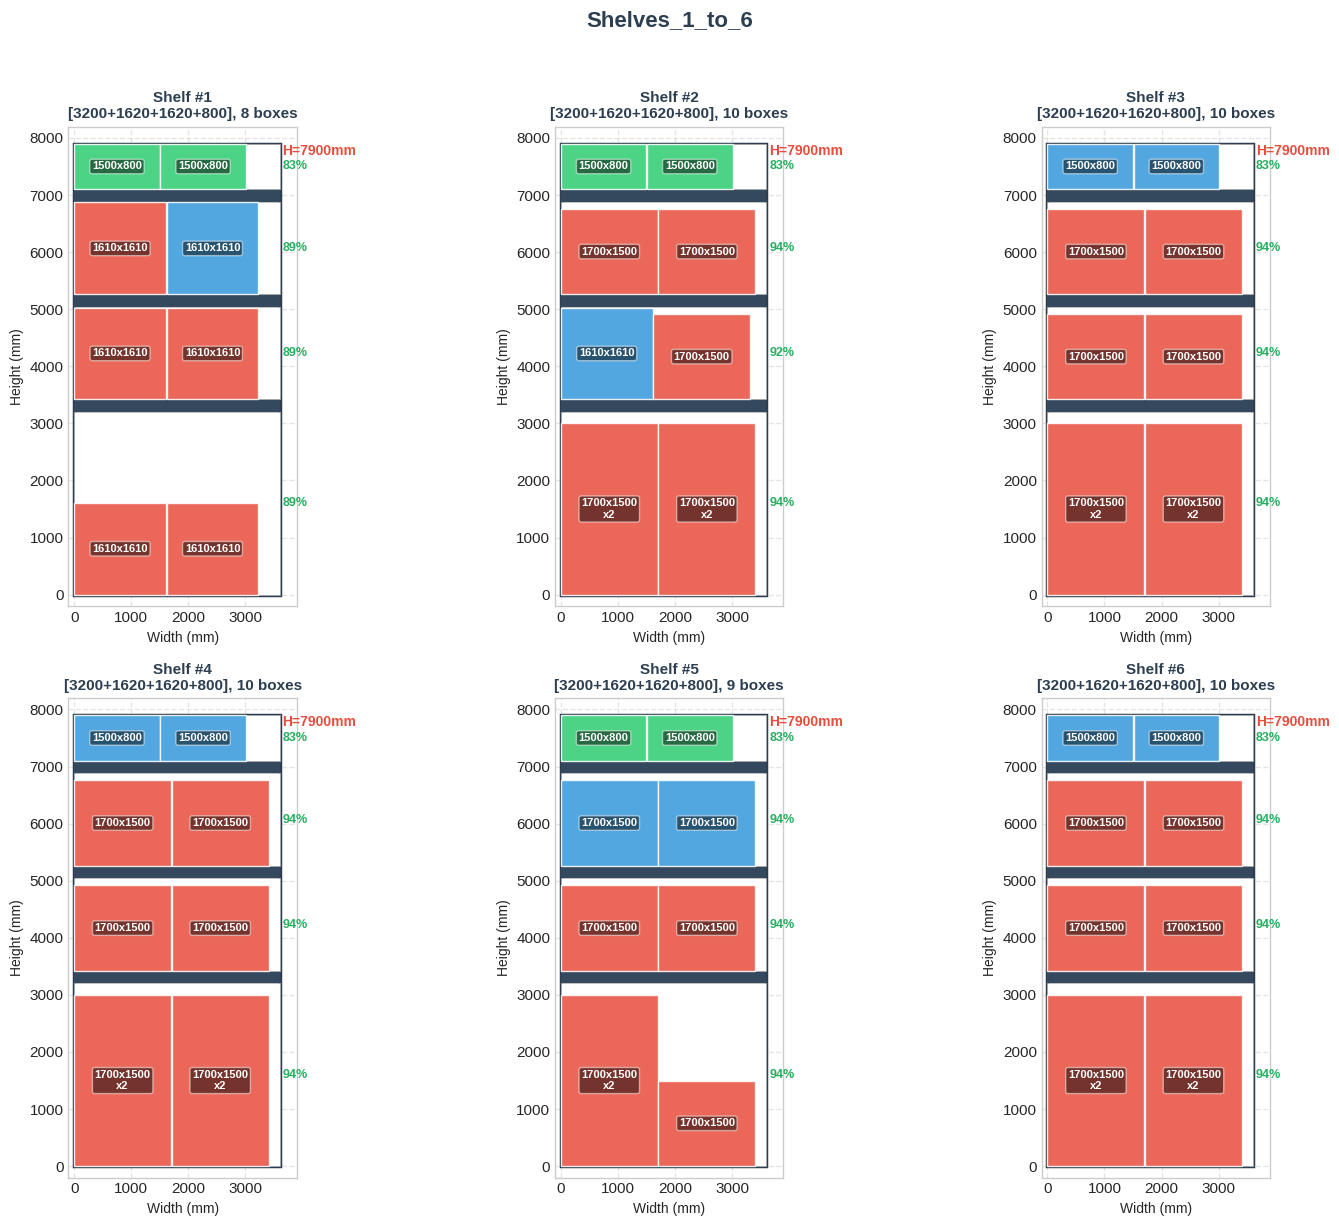

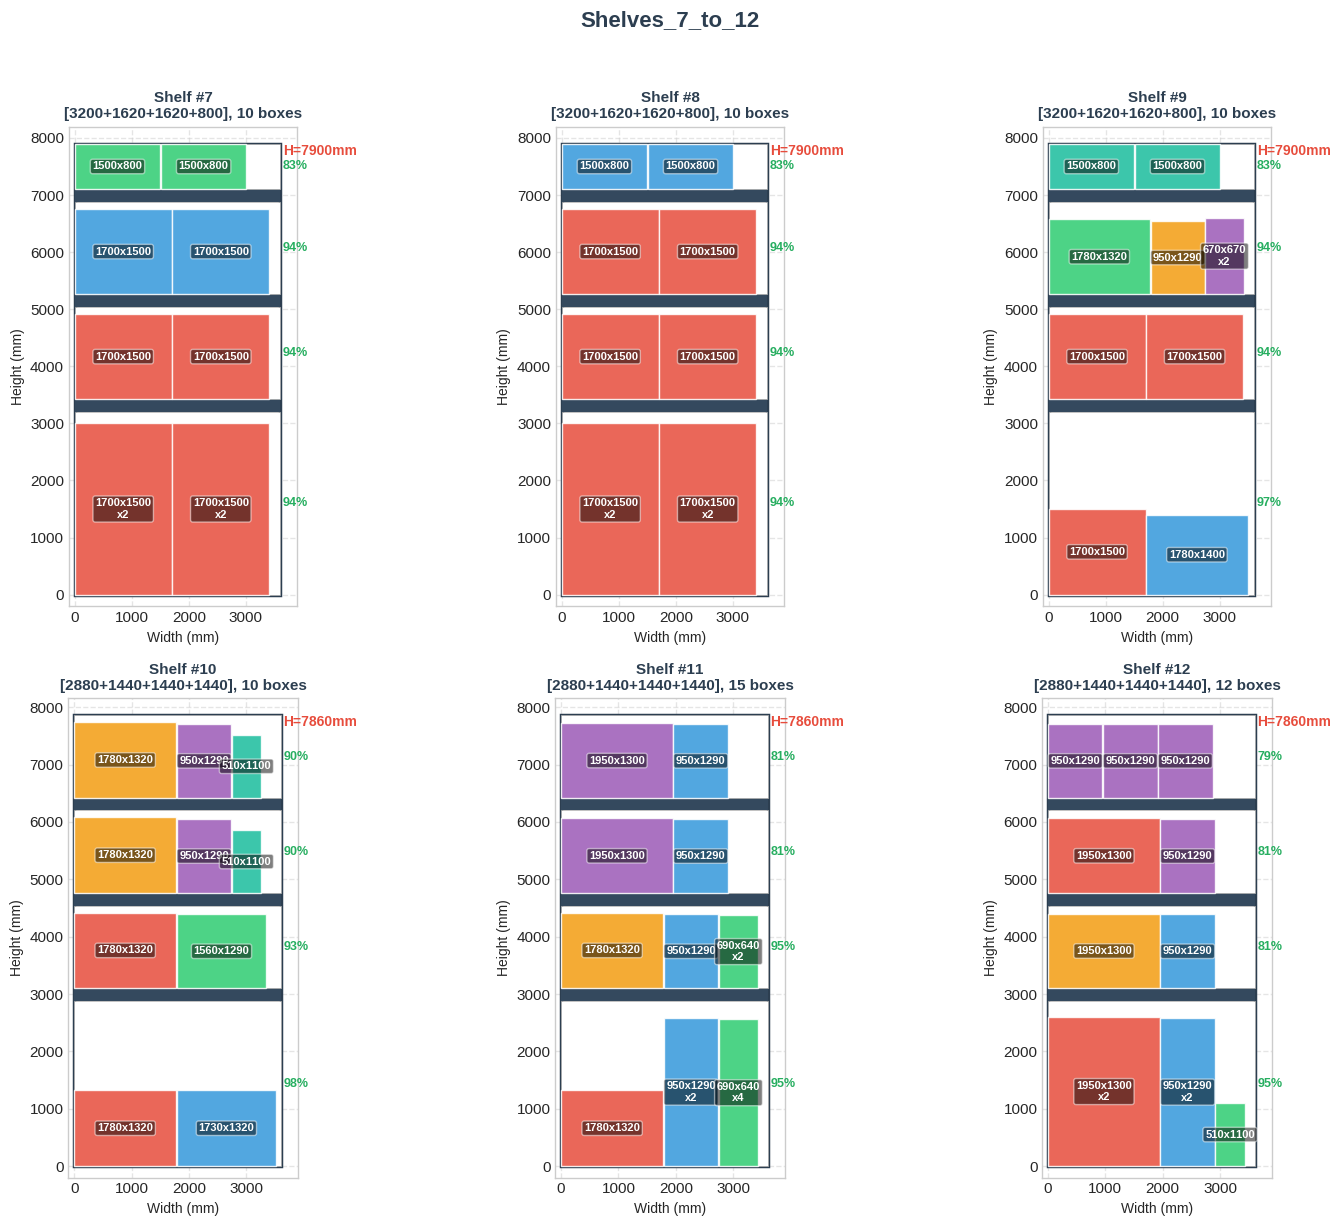

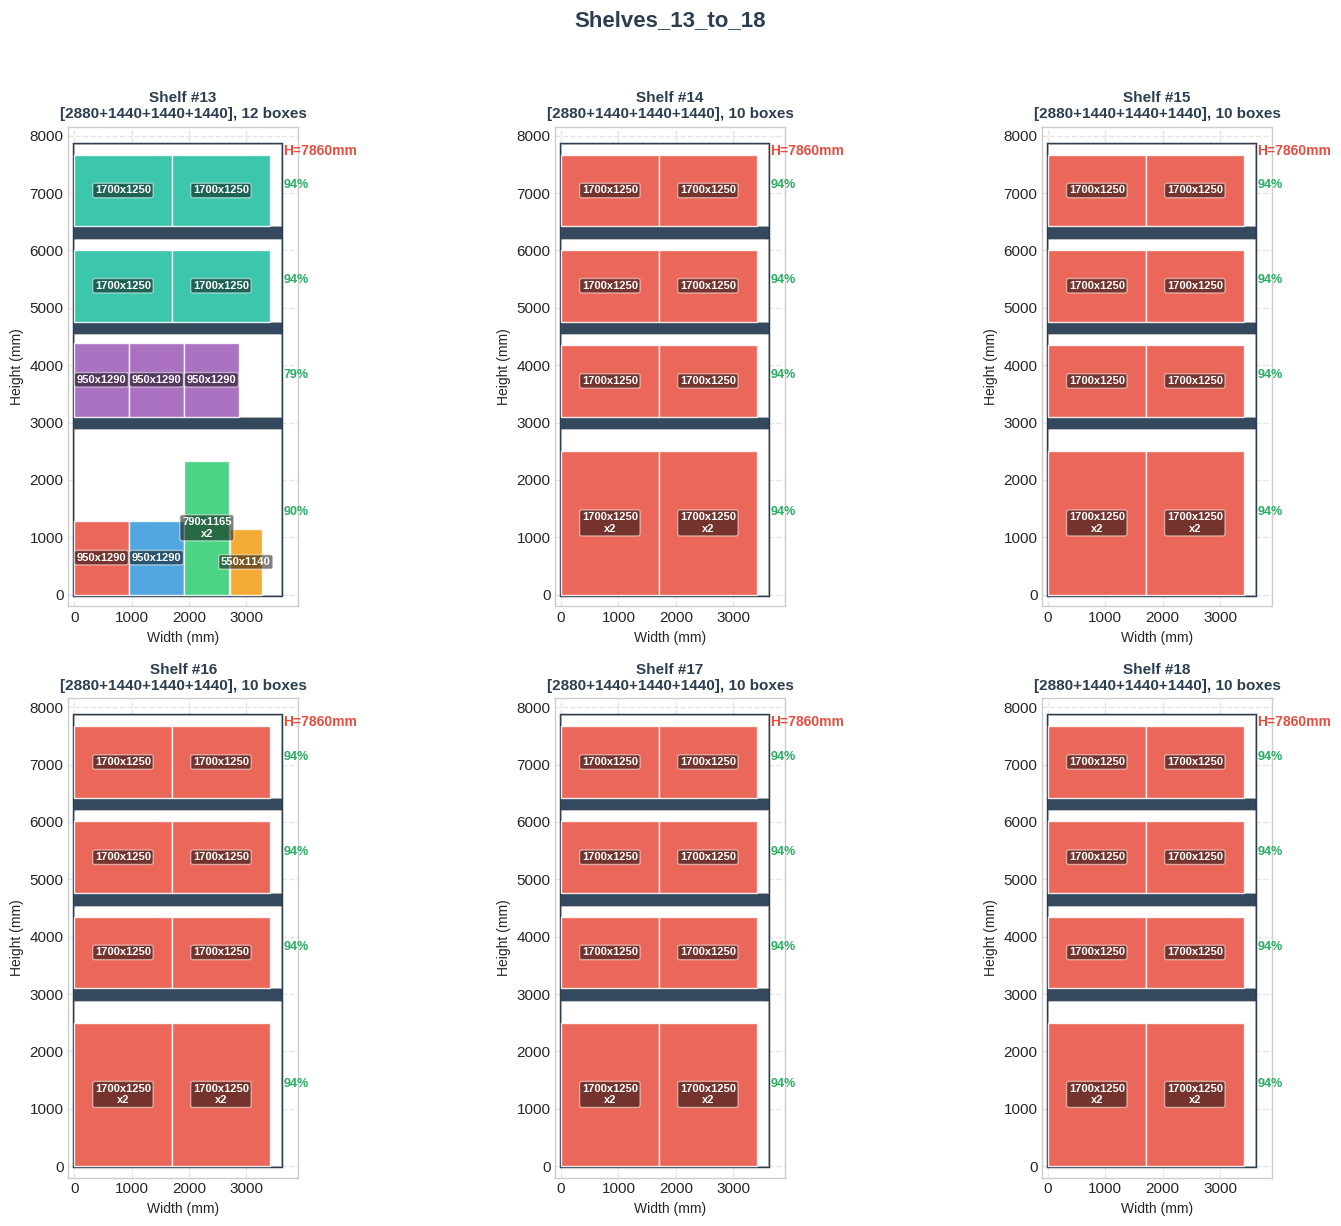

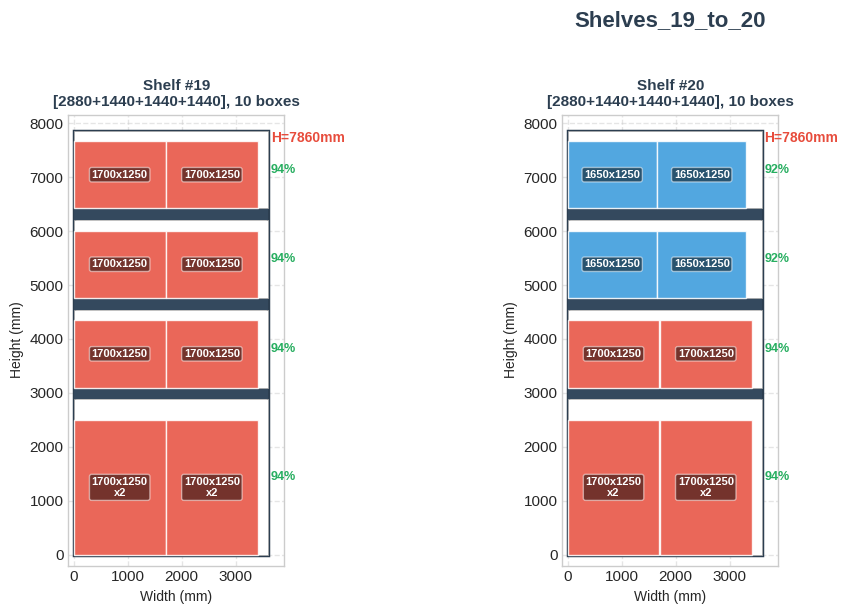

In [30]:
for i in range(0, 20, 6):
        shelf_ids = list(range(i+1, min(i+7, 21)))
        plot_shelf_diagram(result, shelf_ids=shelf_ids, title=f"Shelves_{i+1}_to_{i+len(shelf_ids)}")